about timss dataset:



*   nearly 400 assessment items
*   16 different aspects in math and science
*   Students answer only a small fraction '<20%' of the available assessment  
*   80 variables about Student family, home, academic resource and behavior


*   200 schools in Iran

**Abnormalities**
Converting basic string objects into properly sorted categories
Converting scaled responses into numerical results
Summarizing or combining variables that are redundant across datasets (e.g. test results on paper vs. electronic assessments when students only participate in one type of assessment)
Dropping variables that do not offer any insight into relationship (e.g. unanimously one value)
Renaming variables to give them more consistent and descriptive names





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import data and preprocess

In [ ]:
!pip install pyreadstat

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import re
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

کد کشور ها

In [ ]:
# import the country codes into a dataframe
url='https://raw.githubusercontent.com/sjhaluck/TIMSS-Data-Science/2ec6887132aa2449aca5f0eef6dc0cafbbb1b7f0/data/country_codes.csv'
country_codes = pd.read_csv(url).dropna()
# rename the columns to be consistent with TIMSS information
country_codes.rename(columns = {'ID':'IDCNTRY'}, inplace=True)
# convert IDCNTRY to integers
country_codes['IDCNTRY'] = country_codes['IDCNTRY'].astype(int)
# demonstrate country code information
country_codes


,Country,IDCNTRY
0,Australia,36
1,Bahrain,48
2,Chile,152
3,Chinese Taipei,158
4,Cyprus,196
5,Egypt,818
6,England,926
7,Finland,246
8,France,250
9,Georgia,268


/content/drive/MyDrive/TIMSS/Iran/math_teach.csv

In [ ]:
# read each dataframe from its respective CSV file
school = pd.read_csv('/content/drive/MyDrive/TIMSS/Iran2/school.csv')
stud_ach = pd.read_csv('/content/drive/MyDrive/TIMSS/Iran2/stud_ach.csv')
student = pd.read_csv('/content/drive/MyDrive/TIMSS/Iran2/student.csv')
stud_teach = pd.read_csv('/content/drive/MyDrive/TIMSS/Iran2/stud_teach.csv')
math_teach = pd.read_csv('/content/drive/MyDrive/TIMSS/Iran2/math_teach.csv')
sci_teach = pd.read_csv('/content/drive/MyDrive/TIMSS/Iran2/sci_teach.csv')

**Explore Data**
Explore the structure and values of the data

In [ ]:
sci_teach.head()

,IDCNTRY,IDSCHOOL,IDTEALIN,IDTEACH,IDLINK,ITCOURSE,BTBG01,BTBG02,BTBG03,BTBG04,BTBG05A,BTBG05B,BTBG05C,BTBG05D,BTBG05E,BTBG05F,BTBG05G,BTBG05H,BTBG05I,BTBG06A,BTBG06B,BTBG06C,BTBG06D,BTBG06E,BTBG06F,BTBG06G,BTBG06H,BTBG06I,BTBG06J,BTBG06K,BTBG06L,BTBG07A,BTBG07B,BTBG07C,BTBG07D,BTBG07E,BTBG07F,BTBG07G,BTBG07H,BTBG08A,BTBG08B,BTBG08C,BTBG08D,BTBG08E,BTBG09A,BTBG09B,BTBG09C,BTBG09D,BTBG09E,BTBG09F,BTBG09G,BTBG09H,BTBG10,BTBG11,BTBG12A,BTBG12B,BTBG12C,BTBG12D,BTBG12E,BTBG12F,BTBG12G,BTBG13A,BTBG13B,BTBG13C,BTBG13D,BTBG13E,BTBG13F,BTBG13G,BTBG13H,BTBS14,BTBS15A,BTBS15B,BTBS15C,BTBS15D,BTBS15E,BTBS15F,BTBS15G,BTBS15H,BTBS15I,BTBS15J,BTBS15K,BTBS15L,BTBS15M,BTBS15N,BTBS16A,BTBS16BA,BTBS16BB,BTBS16BC,BTBS16CA,BTBS16CB,BTBS16CC,BTBS16CD,BTBS17AA,BTBS17AB,BTBS17AC,BTBS17AD,BTBS17AE,BTBS17AF,BTBS17AG,BTBS17BA,BTBS17BB,BTBS17BC,BTBS17BD,BTBS17BE,BTBS17BF,BTBS17BG,BTBS17BH,BTBS17CA,BTBS17CB,BTBS17CC,BTBS17CD,BTBS17CE,BTBS17CF,BTBS17CG,BTBS17DA,BTBS17DB,BTBS17DC,BTBS17DD,BTBS18A,BTBS18B,BTBS18CA,BTBS18CB,BTBS18CC,BTBS18CD,BTBS18CE,BTBS19A,BTBS19B,BTBS19C,BTBS19D,BTBS19E,BTBS20,BTBS21AA,BTBS21BA,BTBS21AB,BTBS21BB,BTBS21AC,BTBS21BC,BTBS21AD,BTBS21BD,BTBS21AE,BTBS21BE,BTBS21AF,BTBS21BF,BTBS21AG,BTBS21BG,BTBS22,IDPOP,IDGRADER,IDGRADE,IDSUBJ,ITLANG_T,LCID_T,BTBGEAS,BTBGLSN,BTBGSOS,BTBGTJS,BTBSESI,BTDGEAS,BTDGLSN,BTDGSOS,BTDGTJS,BTDSESI,BTDSMSE,BTDSBIO,BTDSCHE,BTDSPHY,BTDSEAR,VERSION,SCOPE
0,364.0,5001.0,50010202.0,500102.0,2.0,Integrated science,21.0,Female,40–49,<Master’s or equivalent level—ISCED Level 7>,No,No,No,Yes,No,No,No,No,No,High,Medium,Medium,Medium,Low,Low,Medium,Low,Medium,Medium,High,High,Agree a lot,Agree a lot,Agree a lot,Agree a little,Agree a lot,Agree a little,Agree a little,Agree a lot,Very often,Very often,Very often,Very often,Often,Agree a lot,Agree a lot,Disagree a lot,Agree a lot,Agree a lot,Agree a little,Agree a little,Agree a lot,33.0,0.0,Every or almost every lesson,Every or almost every lesson,About half the lessons,About half the lessons,Every or almost every lesson,About half the lessons,Every or almost every lesson,A lot,Some,Some,A lot,Not at all,Some,Some,Not at all,135.0,Every or almost every lesson,About half the lessons,About half the lessons,About half the lessons,About half the lessons,Some lessons,Some lessons,About half the lessons,About half the lessons,Some lessons,About half the lessons,Some lessons,Some lessons,Never,Yes,No,No,Yes,Once or twice a month,Once or twice a month,Once or twice a month,Once or twice a month,Mostly taught before this year,Mostly taught this year,Mostly taught before this year,Mostly taught this year,Not yet taught or just introduced,Not yet taught or just introduced,Not yet taught or just introduced,Mostly taught before this year,Not yet taught or just introduced,Mostly taught before this year,Mostly taught this year,Mostly taught this year,Mostly taught this year,Not yet taught or just introduced,Not yet taught or just introduced,Mostly taught before this year,Mostly taught before this year,Not yet taught or just introduced,Not yet taught or just introduced,Mostly taught this year,Mostly taught this year,Not yet taught or just introduced,Mostly taught before this year,Not yet taught or just introduced,Mostly taught before this year,Not yet taught or just introduced,Less than once a week,16–30 minutes,Sometimes,Sometimes,Sometimes,Sometimes,Sometimes,A lot,A lot,Some,Some,NaN,Never,No,No,No,No,No,No,Yes,No,No,Yes,Yes,No,No,No,16–35 hours,Pop 2,Upper Grade,Grade 8,Science,Persian,Persian (Iran),7.93956,9.11668,11.14932,10.82008,10.24199,Medium Emphasis,Somewhat Limited,Very Safe and Orderly,Very Satisfied,Less than Half the Lessons,Major in Science but not in Science Education,57.14286,62.5,57.14286,50.0,4.0,Public Use File (PUF)
1,364.0,5002.0,50020202.0,500202.0,2.0,Integrated science,17.0,Female,40–49,<Master’s or equivalent level—ISCED Level 7>,No,No,No,No,No,No,No,No,Yes,High,High,Very high,High,High,High,High,Medium,High,High,Very high,High,Agree a lot,Agree a lot,Agre

In [ ]:
# Select the relevant columns
columns_to_keep = {
    'IDCNTRY': 'IDCNTRY',
    'IDSCHOOL': 'IDSCHOOL',
    'IDTEACH': 'IDTEACH',
    'BTBG01': 'Years_Teaching',
    'BTBG04': 'Education_Level_Completed',
    'BTBG05A': 'Major_Mathematics',
    'BTBG05B': 'Major_Biology',
    'BTBG05C': 'Major_Physics',
    'BTBG05D': 'Major_Chemistry',
    'BTBG05E': 'Major_Earth_Science',
    'BTBG05F': 'Major_Edu_Mathematics',
    'BTBG05G': 'Major_Edu_Science',
    'BTBG05H': 'Major_Edu_General',
    'BTBS15A': 'Ask_Explain_New_Content',
    'BTBS15B': 'Ask_Observe_Phenomena',
    'BTBS15C': 'Ask_Demonstrate_Experiment',
    'BTBS15D': 'Ask_Plan_Experiments',
    'BTBS15E': 'Ask_Conduct_Experiments',
    'BTBS15F': 'Ask_Present_Data',
    'BTBS15G': 'Ask_Interpret_Data',
    'BTBS15H': 'Ask_Use_Evidence',
    'BTBS15I': 'Ask_Read_Textbooks',
    'BTBS15J': 'Ask_Memorize_Facts',
    'BTBS15K': 'Ask_Use_Formulas',
    'BTBS15L': 'Ask_Do_Field_Work',
    'BTBS15M': 'Ask_Mixed_Ability_Groups',
    'BTBS15N': 'Ask_Same_Ability_Groups',
    'BTBS18A': 'Frequency_Sci_Homework',
    'BTBS18B': 'Time_Spent_Homework',
    'BTBS16A': 'Computer_Tablet_Availability',
    'BTBG10': 'Class_Size',
    'BTBGEAS': 'School_Emphasis_Academic_Success',
    'BTBSESI': 'Teachers_Emphasis_Science_Investigation'
}

# Create a new dataframe with selected columns and rename them
sci_teach_filtered = sci_teach[columns_to_keep.keys()].rename(columns=columns_to_keep)

# Display the first few rows of the new dataframe
sci_teach_filtered.head()


,IDCNTRY,IDSCHOOL,IDTEACH,Years_Teaching,Education_Level_Completed,Major_Mathematics,Major_Biology,Major_Physics,Major_Chemistry,Major_Earth_Science,Major_Edu_Mathematics,Major_Edu_Science,Major_Edu_General,Ask_Explain_New_Content,Ask_Observe_Phenomena,Ask_Demonstrate_Experiment,Ask_Plan_Experiments,Ask_Conduct_Experiments,Ask_Present_Data,Ask_Interpret_Data,Ask_Use_Evidence,Ask_Read_Textbooks,Ask_Memorize_Facts,Ask_Use_Formulas,Ask_Do_Field_Work,Ask_Mixed_Ability_Groups,Ask_Same_Ability_Groups,Frequency_Sci_Homework,Time_Spent_Homework,Computer_Tablet_Availability,Class_Size,School_Emphasis_Academic_Success,Teachers_Emphasis_Science_Investigation
0,364.0,5001.0,500102.0,21.0,<Master’s or equivalent level—ISCED Level 7>,No,No,No,Yes,No,No,No,No,Every or almost every lesson,About half the lessons,About half the lessons,About half the lessons,About half the lessons,Some lessons,Some lessons,About half the lessons,About half the lessons,Some lessons,About half the lessons,Some lessons,Some lessons,Never,Less than once a week,16–30 minutes,Yes,33.0,7.93956,10.24199
1,364.0,5002.0,500202.0,17.0,<Master’s or equivalent level—ISCED Level 7>,No,No,No,No,No,No,No,No,Every or almost every lesson,About half the lessons,Some lessons,About half the lessons,About half the lessons,Every or almost every lesson,Every or almost every lesson,About half the lessons,Every or almost every lesson,Every or almost every lesson,About half the lessons,Some lessons,Some lessons,Some lessons,Less than once a week,15 minutes or less,No,35.0,11.85103,11.31862
2,364.0,5003.0,500302.0,18.0,<Master’s or equivalent level—ISCED Level 7>,No,No,No,No,No,No,No,Yes,Every or almost every lesson,About half the lessons,Some lessons,Some lessons,Some lessons,Some lessons,About half the lessons,Some lessons,About half the lessons,Every or almost every lesson,About half the lessons,Some lessons,Some lessons,Some lessons,I do not assign science homework,NaN,No,13.0,7.30893,8.81776
3,364.0,5004.0,500401.0,2.0,<Master’s or equivalent level—ISCED Level 7>,No,No,Yes,No,No,No,No,No,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,About half the lessons,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,About half the lessons,Every or almost every lesson,About half the lessons,Some lessons,Some lessons,I do not assign science homework,NaN,No,32.0,8.84690,13.88950
4,364.0,5005.0,500502.0,30.0,<Master’s or equivalent level—ISCED Level 7>,No,No,No,No,No,No,Yes,No,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,About half the lessons,Every or almost every lesson,Some lessons,1 or 2 times a week,61–90 minutes,Yes,36.0,10.35236,14.62251


In [ ]:
sci_teach_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 33 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   IDCNTRY                                  220 non-null    float64
 1   IDSCHOOL                                 220 non-null    float64
 2   IDTEACH                                  220 non-null    float64
 3   Years_Teaching                           220 non-null    float64
 4   Education_Level_Completed                219 non-null    object 
 5   Major_Mathematics                        217 non-null    object 
 6   Major_Biology                            218 non-null    object 
 7   Major_Physics                            217 non-null    object 
 8   Major_Chemistry                          217 non-null    object 
 9   Major_Earth_Science                      218 non-null    object 
 10  Major_Edu_Mathematics                    217 non-n

In [ ]:
math_teach.head()

,IDCNTRY,IDSCHOOL,IDTEALIN,IDTEACH,IDLINK,ITCOURSE,BTBG01,BTBG02,BTBG03,BTBG04,BTBG05A,BTBG05B,BTBG05C,BTBG05D,BTBG05E,BTBG05F,BTBG05G,BTBG05H,BTBG05I,BTBG06A,BTBG06B,BTBG06C,BTBG06D,BTBG06E,BTBG06F,BTBG06G,BTBG06H,BTBG06I,BTBG06J,BTBG06K,BTBG06L,BTBG07A,BTBG07B,BTBG07C,BTBG07D,BTBG07E,BTBG07F,BTBG07G,BTBG07H,BTBG08A,BTBG08B,BTBG08C,BTBG08D,BTBG08E,BTBG09A,BTBG09B,BTBG09C,BTBG09D,BTBG09E,BTBG09F,BTBG09G,BTBG09H,BTBG10,BTBG11,BTBG12A,BTBG12B,BTBG12C,BTBG12D,BTBG12E,BTBG12F,BTBG12G,BTBG13A,BTBG13B,BTBG13C,BTBG13D,BTBG13E,BTBG13F,BTBG13G,BTBG13H,BTBM14,BTBM15A,BTBM15B,BTBM15C,BTBM15D,BTBM15E,BTBM15F,BTBM15G,BTBM15H,BTBM16,BTBM17A,BTBM17BA,BTBM17BB,BTBM17BC,BTBM17CA,BTBM17CB,BTBM17CC,BTBM17CD,BTBM18AA,BTBM18AB,BTBM18AC,BTBM18BA,BTBM18BB,BTBM18BC,BTBM18BD,BTBM18BE,BTBM18BF,BTBM18BG,BTBM18CA,BTBM18CB,BTBM18CC,BTBM18CD,BTBM18CE,BTBM18CF,BTBM18DA,BTBM18DB,BTBM18DC,BTBM18DD,BTBM18DE,BTBM18DF,BTBM19A,BTBM19B,BTBM19CA,BTBM19CB,BTBM19CC,BTBM19CD,BTBM19CE,BTBM20A,BTBM20B,BTBM20C,BTBM20D,BTBM20E,BTBM21,BTBM22AA,BTBM22BA,BTBM22AB,BTBM22BB,BTBM22AC,BTBM22BC,BTBM22AD,BTBM22BD,BTBM22AE,BTBM22BE,BTBM22AF,BTBM22BF,BTBM22AG,BTBM22BG,BTBM23,IDPOP,IDGRADER,IDGRADE,IDSUBJ,ITLANG_T,LCID_T,BTBGEAS,BTBGLSN,BTBGSOS,BTBGTJS,BTDGEAS,BTDGLSN,BTDGSOS,BTDGTJS,BTDMMME,BTDMNUM,BTDMALG,BTDMGEO,BTDMDAT,VERSION,SCOPE
0,364.0,5001.0,50010101.0,500101.0,1.0,Mathematics,27.0,Female,40–49,<Short-cycle tertiary education—ISCED Level 5>,Yes,No,No,No,No,No,No,No,No,High,Medium,Medium,Medium,Low,Low,Medium,Low,Medium,Medium,High,High,Agree a lot,Agree a lot,Agree a lot,Agree a little,Agree a lot,Disagree a little,Agree a lot,Agree a lot,Very often,Very often,Very often,Very often,Very often,Agree a lot,Agree a lot,Disagree a lot,Disagree a lot,Agree a little,Disagree a lot,Disagree a lot,Disagree a lot,33.0,0.0,About half the lessons,Some lessons,Some lessons,About half the lessons,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,Some,Some,A lot,Some,Not at all,Some,Some,Some,90.0,Every or almost every lesson,About half the lessons,Some lessons,Some lessons,Some lessons,Some lessons,About half the lessons,Some lessons,"Yes, with restricted use",No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mostly taught this year,Mostly taught this year,Mostly taught before this year,Mostly taught this year,Not yet taught or just introduced,Not yet taught or just introduced,Not yet taught or just introduced,Not yet taught or just introduced,Not yet taught or just introduced,Mostly taught this year,Mostly taught this year,Mostly taught this year,Mostly taught this year,Mostly taught this year,Not yet taught or just introduced,Mostly taught this year,Mostly taught this year,Mostly taught this year,Mostly taught this year,Mostly taught this year,Mostly taught this year,Not yet taught or just introduced,3 or 4 times a week,31–60 minutes,Always or almost always,Sometimes,Sometimes,Always or almost always,Always or almost always,A lot,A lot,A lot,A lot,NaN,Never,Yes,Yes,No,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,No,NaN,More than 35 hours,Pop 2,Upper Grade,Grade 8,Mathematics,Persian,Persian (Iran),7.93956,9.11668,11.14932,11.74559,Medium Emphasis,Somewhat Limited,Very Safe and Orderly,Very Satisfied,Major in Mathematics but not in Mathematics Ed...,100.0,28.57143,83.33333,83.33333,4.0,Public Use File (PUF)
1,364.0,5002.0,50020101.0,500201.0,1.0,Mathematics,15.0,Female,30–39,<Bachelor’s or equivalent level—ISCED Level 6>,No,No,No,No,No,Yes,No,No,No,Very high,High,High,High,Low,Low,High,Medium,Medium,Medium,High,Very high,Agree a little,Agree a lot,Agree a lot,Agree a little,Disagree a little,Agree a little,Agree a lot,Agree a lot,Often,Often,Often,Often,Often,Agree a lot,Agree a lot,Agree a lot,Agree a little,Agree a little,Disagree a little,Agree a little,Disagree a little,35.0,5.0,Some lessons,About half the lessons,Some lessons,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,Every or almost every lesson,A lot,Some,Some,Some,Some,Some,Some

In [ ]:

# Define the mapping of original column names to new comprehensive names
columns_to_keep_math = {
    'IDCNTRY': 'IDCNTRY',
    'IDSCHOOL': 'IDSCHOOL',
    'IDTEACH': 'IDTEACH',
    'BTBG01': 'Years_Teaching',
    'BTBG04': 'Education_Level_Completed',
    'BTBG05A': 'Major_Mathematics',
    'BTBG05B': 'Major_Biology',
    'BTBG05C': 'Major_Physics',
    'BTBG05D': 'Major_Chemistry',
    'BTBG05E': 'Major_Earth_Science',
    'BTBG05F': 'Major_Edu_Mathematics',
    'BTBG05G': 'Major_Edu_Science',
    'BTBG05H': 'Major_Edu_General',
    'BTBM15A': 'Ask_Explain_New_Content',
    'BTBM15B': 'Ask_Explain_How_to_Solve',
    'BTBM15C': 'Ask_Memorize_Rules',
    'BTBM15D': 'Ask_Practice_Procedures',
    'BTBM15E': 'Ask_Apply_Learned_Concepts',
    'BTBM15F': 'Ask_Work_in_Whole_Class',
    'BTBM15G': 'Ask_Mixed_Ability_Groups',
    'BTBM15H': 'Ask_Same_Ability_Groups',
    'BTBM19A': 'Homework_Assigned_Frequency',
    'BTBM19B': 'Time_Spent_on_Homework',
    'BTBM17A': 'Computer_Tablet_Availability',
    'BTBG10': 'Number_of_Students_in_Class',
    'BTBGEAS': 'School_Emphasis_Academic_Success',
    'BTBGLSN': 'Teaching_Limited_by_Student_Needs'
}

# Create a new dataframe with selected columns and rename them
math_teach_filtered = math_teach[columns_to_keep_math.keys()].rename(columns=columns_to_keep_math)

# Display the first few rows of the new dataframe
math_teach_filtered.head()


,IDCNTRY,IDSCHOOL,IDTEACH,Years_Teaching,Education_Level_Completed,Major_Mathematics,Major_Biology,Major_Physics,Major_Chemistry,Major_Earth_Science,Major_Edu_Mathematics,Major_Edu_Science,Major_Edu_General,Ask_Explain_New_Content,Ask_Explain_How_to_Solve,Ask_Memorize_Rules,Ask_Practice_Procedures,Ask_Apply_Learned_Concepts,Ask_Work_in_Whole_Class,Ask_Mixed_Ability_Groups,Ask_Same_Ability_Groups,Homework_Assigned_Frequency,Time_Spent_on_Homework,Computer_Tablet_Availability,Number_of_Students_in_Class,School_Emphasis_Academic_Success,Teaching_Limited_by_Student_Needs
0,364.0,5001.0,500101.0,27.0,<Short-cycle tertiary education—ISCED Level 5>,Yes,No,No,No,No,No,No,No,Every or almost every lesson,About half the lessons,Some lessons,Some lessons,Some lessons,Some lessons,About half the lessons,Some lessons,3 or 4 times a week,31–60 minutes,No,33.0,7.93956,9.11668
1,364.0,5002.0,500201.0,15.0,<Bachelor’s or equivalent level—ISCED Level 6>,No,No,No,No,No,Yes,No,No,Every or almost every lesson,Every or almost every lesson,Never,About half the lessons,About half the lessons,Some lessons,About half the lessons,Some lessons,1 or 2 times a week,31–60 minutes,No,35.0,10.05102,8.63238
2,364.0,5003.0,500301.0,12.0,<Short-cycle tertiary education—ISCED Level 5>,No,No,No,No,No,No,Yes,No,Every or almost every lesson,About half the lessons,Some lessons,Never,Some lessons,Every or almost every lesson,Every or almost every lesson,About half the lessons,I do not assign mathematics homework,NaN,No,13.0,7.30893,11.93195
3,364.0,5004.0,500401.0,2.0,<Master’s or equivalent level—ISCED Level 7>,No,No,Yes,No,No,No,No,No,Every or almost every lesson,Every or almost every lesson,Some lessons,About half the lessons,About half the lessons,Every or almost every lesson,About half the lessons,About half the lessons,1 or 2 times a week,31–60 minutes,No,32.0,8.84690,7.67828
4,364.0,5005.0,500501.0,27.0,<Bachelor’s or equivalent level—ISCED Level 6>,Yes,No,No,No,No,No,No,No,Every or almost every lesson,Every or almost every lesson,Some lessons,Some lessons,About half the lessons,About half the lessons,About half the lessons,Every or almost every lesson,1 or 2 times a week,61–90 minutes,No,36.0,9.44792,10.14509


In [ ]:
math_teach_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   IDCNTRY                            220 non-null    float64
 1   IDSCHOOL                           220 non-null    float64
 2   IDTEACH                            220 non-null    float64
 3   Years_Teaching                     220 non-null    float64
 4   Education_Level_Completed          219 non-null    object 
 5   Major_Mathematics                  219 non-null    object 
 6   Major_Biology                      220 non-null    object 
 7   Major_Physics                      220 non-null    object 
 8   Major_Chemistry                    220 non-null    object 
 9   Major_Earth_Science                219 non-null    object 
 10  Major_Edu_Mathematics              220 non-null    object 
 11  Major_Edu_Science                  220 non-null    object 

In [ ]:
stud_teach.head()

,IDCNTRY,IDBOOK,IDSCHOOL,IDCLASS,IDSTUD,IDTEALIN,IDTEACH,IDLINK,IDPOP,IDGRADER,IDGRADE,IDSUBJ,ITCOURSE,MATSUBJ,SCISUBJ,NMTEACH,NSTEACH,NTEACH,MATWGT,SCIWGT,TCHWGT,JKREP,JKZONE,BSSENV01,BSSENV02,BSSENV03,BSSENV04,BSSENV05,BSMIBM01,BSMIBM02,BSMIBM03,BSMIBM04,BSMIBM05,BSSIBM01,BSSIBM02,BSSIBM03,BSSIBM04,BSSIBM05,VERSION,SCOPE,mmat_avg,ssci_avg,malg_avg,mapp_avg,mdat_avg,mgeo_avg,mkno_avg,mnum_avg,mrea_avg,sapp_avg,sbio_avg,sche_avg,sear_avg,skno_avg,sphy_avg,srea_avg
0,364.0,Booklet 12,5001.0,500104.0,50010401.0,50010202.0,500102.0,2.0,Pop 2,Upper Grade,Grade 8,Science,Integrated science,0.0,1.0,1.0,1.0,2.0,0.00000,111.09855,55.549275,1.0,25.0,469.81394,511.13810,433.44402,443.20077,404.32027,At or above 400 but below 475,At or above 400 but below 475,At or above 400 but below 475,At or above 475 but below 550,At or above 475 but below 550,At or above 400 but below 475,At or above 400 but below 475,At or above 400 but below 475,At or above 475 but below 550,At or above 475 but below 550,4.0,Public Use File (PUF),462.408384,482.862002,461.856756,463.346092,525.414708,466.764814,449.538762,462.690390,468.242180,503.069034,473.045640,518.303026,442.425234,437.306132,470.345018,514.33973
1,364.0,Booklet 12,5001.0,500104.0,50010401.0,50010101.0,500101.0,1.0,Pop 2,Upper Grade,Grade 8,Mathematics,Mathematics,1.0,0.0,1.0,1.0,2.0,111.09855,0.00000,55.549275,1.0,25.0,469.81394,511.13810,433.44402,443.20077,404.32027,At or above 400 but below 475,At or above 400 but below 475,At or above 400 but below 475,At or above 475 but below 550,At or above 475 but below 550,At or above 400 but below 475,At or above 400 but below 475,At or above 400 but below 475,At or above 475 but below 550,At or above 475 but below 550,4.0,Public Use File (PUF),462.408384,482.862002,461.856756,463.346092,525.414708,466.764814,449.538762,462.690390,468.242180,503.069034,473.045640,518.303026,442.425234,437.306132,470.345018,514.33973
2,364.0,Booklet 13,5001.0,500104.0,50010402.0,50010101.0,500101.0,1.0,Pop 2,Upper Grade,Grade 8,Mathematics,Mathematics,1.0,0.0,1.0,1.0,2.0,111.09855,0.00000,55.549275,1.0,25.0,394.07319,429.88578,492.06523,491.10218,449.16622,At or above 550 but below 625,At or above 550 but below 625,At or above 550 but below 625,At or above 550 but below 625,At or above 550 but below 625,At or above 475 but below 550,At or above 550 but below 625,At or above 550 but below 625,At or above 475 but below 550,At or above 550 but below 625,4.0,Public Use File (PUF),590.785158,566.929916,554.520330,582.980668,535.749222,595.562238,603.030864,579.501208,583.418388,489.686874,541.065484,572.764446,488.357758,511.869718,541.756578,536.91796
3,364.0,Booklet 13,5001.0,500104.0,50010402.0,50010202.0,500102.0,2.0,Pop 2,Upper Grade,Grade 8,Science,Integrated science,0.0,1.0,1.0,1.0,2.0,0.00000,111.09855,55.549275,1.0,25.0,394.07319,429.88578,492.06523,491.10218,449.16622,At or above 550 but below 625,At or above 550 but below 625,At or above 550 but below 625,At or above 550 but below 625,At or above 550 but below 625,At or above 475 but below 550,At or above 550 but below 625,At or above 550 but below 625,At or above 475 but below 550,At or above 550 but below 625,4.0,Public Use File (PUF),590.785158,566.929916,554.520330,582.980668,535.749222,595.562238,603.030864,579.501208,583.418388,489.686874,541.065484,572.764446,488.357758,511.869718,541.756578,536.91796
4,364.0,Booklet 14,5001.0,500104.0,50010403.0,50010202.0,500102.0,2.0,Pop 2,Upper Grade,Grade 8,Science,Integrated science,0.0,1.0,1.0,1.0,2.0,0.00000,111.09855,55.549275,1.0,25.0,384.75848,375.41727,445.48716,460.76101,427.85560,At or above 400 but below 475,Below 400,Below 400,Below 400,Below 400,At or above 400 but below 475,Below 400,Below 400,At or above 400 but below 475,At or above 400 but below 475,4.0,Public Use File (PUF),359.175968,404.125698,398.753392,349.178170,356.374814,378.886296,352.798384,367.180672,363.828354,448.888804,414.837148,389.036172,432.157996,423.247890,424.632514,429.78072


In [ ]:
stud_teach_filtered=stud_teach[['IDCNTRY', 'IDBOOK', 'IDSCHOOL', 'IDSTUD', 'IDTEACH']]
stud_teach_filtered.head()

,IDCNTRY,IDBOOK,IDSCHOOL,IDSTUD,IDTEACH
0,364.0,Booklet 12,5001.0,50010401.0,500102.0
1,364.0,Booklet 12,5001.0,50010401.0,500101.0
2,364.0,Booklet 13,5001.0,50010402.0,500101.0
3,364.0,Booklet 13,5001.0,50010402.0,500102.0
4,364.0,Booklet 14,5001.0,50010403.0,500102.0


In [ ]:
student.head()

,IDCNTRY,IDBOOK,IDSCHOOL,IDCLASS,IDSTUD,BSBG01,BSBG03,BSBG04,BSBG05A,BSBG05B,BSBG05C,BSBG05D,BSBG05E,BSBG05F,BSBG05G,BSBG05H,BSBG05I,BSBG06A,BSBG06B,BSBG07,BSBG08A,BSBG08B,BSBG09A,BSBG09B,BSBG10,BSBG11A,BSBG11B,BSBG12A,BSBG12B,BSBG12C,BSBG12D,BSBG12E,BSBG12F,BSBG13A,BSBG13B,BSBG13C,BSBG13D,BSBG13E,BSBG14A,BSBG14B,BSBG14C,BSBG14D,BSBG14E,BSBG14F,BSBG14G,BSBG14H,BSBG14I,BSBG14J,BSBG14K,BSBG14L,BSBG14M,BSBG14N,BSBM15,BSBM16A,BSBM16B,BSBM16C,BSBM16D,BSBM16E,BSBM16F,BSBM16G,BSBM16H,BSBM16I,BSBM17A,BSBM17B,BSBM17C,BSBM17D,BSBM17E,BSBM17F,BSBM17G,BSBM18A,BSBM18B,BSBM18C,BSBM18D,BSBM18E,BSBM18F,BSBM19A,BSBM19B,BSBM19C,BSBM19D,BSBM19E,BSBM19F,BSBM19G,BSBM19H,BSBM19I,BSBM20A,BSBM20B,BSBM20C,BSBM20D,BSBM20E,BSBM20F,BSBM20G,BSBM20H,BSBM20I,BSBS21,BSBS22A,BSBS22B,BSBS22C,BSBS22D,BSBS22E,BSBS22F,BSBS22G,BSBS22H,BSBS22I,BSBS23A,BSBS23B,BSBS23C,BSBS23D,BSBS23E,BSBS23F,BSBS23G,BSBS24A,BSBS24B,BSBS24C,BSBS24D,BSBS24E,BSBS24F,BSBS24G,BSBS24H,BSBS25A,BSBS25B,BSBS25C,BSBS25D,BSBS25E,BSBS25F,BSBS25G,BSBS25H,BSBS25I,BSBM26AA,BSBS26AB,BSBM26BA,BSBS26BB,BSBM27AA,BSBS27AB,BSBM27BA,BSBS27BB,BSBB21,BSBB22,BSBB23A,BSBB23B,BSBB23C,BSBB23D,BSBB23E,BSBB23F,BSBB23G,BSBB23H,BSBB23I,BSBB24A,BSBB24B,BSBB24C,BSBB24D,BSBB24E,BSBB24F,BSBB24G,BSBB25A,BSBB25B,BSBB25C,BSBB25D,BSBB25E,BSBB25F,BSBB25G,BSBB25H,BSBE26,BSBE27,BSBE28A,BSBE28B,BSBE28C,BSBE28D,BSBE28E,BSBE28F,BSBE28G,BSBE28H,BSBE28I,BSBE29A,BSBE29B,BSBE29C,BSBE29D,BSBE29E,BSBE29F,BSBE29G,BSBE30A,BSBE30B,BSBE30C,BSBE30D,BSBE30E,BSBE30F,BSBE30G,BSBE30H,BSBC31,BSBC32,BSBC33A,BSBC33B,BSBC33C,BSBC33D,BSBC33E,BSBC33F,BSBC33G,BSBC33H,BSBC33I,BSBC34A,BSBC34B,BSBC34C,BSBC34D,BSBC34E,BSBC34F,BSBC34G,BSBC35A,BSBC35B,BSBC35C,BSBC35D,BSBC35E,BSBC35F,BSBC35G,BSBC35H,BSBP36,BSBP37,BSBP38A,BSBP38B,BSBP38C,BSBP38D,BSBP38E,BSBP38F,BSBP38G,BSBP38H,BSBP38I,BSBP39A,BSBP39B,BSBP39C,BSBP39D,BSBP39E,BSBP39F,BSBP39G,BSBP40A,BSBP40B,BSBP40C,BSBP40D,BSBP40E,BSBP40F,BSBP40G,BSBP40H,BSBS41A,BSBS41B,BSBS41C,BSBS41D,BSBS41E,BSBS41F,BSBS41G,BSBS41H,BSBS41I,BSBM42AA,BSBB42AB,BSBE42AC,BSBC42AD,BSBP42AE,BSBM42BA,BSBB42BB,BSBE42BC,BSBC42BD,BSBP42BE,BSBM43AA,BSBS43AB,BSBM43BA,BSBS43BB,BSBE01A,BSBE01BA,BSBE01BB,BSBE01BC,BSBE01BD,BSBE01BE,BSBE01BF,BSBE02A,BSBE02B,BSBE02C,BSBE02D,BSBE03A,BSBE03B,BSBE03C,BSBE03D,BSBE03E,BSBE03F,BSBE03G,BSBE04A,BSBE04B,BSBE04C,BSBE04D,BSBE04E,BSBE04F,BSBE04G,BSBE04H,IDPOP,IDGRADER,IDGRADE,ITLANG_SQ,LCID_SQ,ITLANG_SA,LCID_SA,ITSEX,BSDAGE,ITADMINI,TOTWGT,HOUWGT,SENWGT,WGTADJ1,WGTADJ2,WGTADJ3,WGTFAC1,WGTFAC2,WGTFAC3,JKREP,JKZONE,BSMMAT01,BSMMAT02,BSMMAT03,BSMMAT04,BSMMAT05,BSSSCI01,BSSSCI02,BSSSCI03,BSSSCI04,BSSSCI05,BSMALG01,BSMALG02,BSMALG03,BSMALG04,BSMALG05,BSMAPP01,BSMAPP02,BSMAPP03,BSMAPP04,BSMAPP05,BSMDAT01,BSMDAT02,BSMDAT03,BSMDAT04,BSMDAT05,BSMGEO01,BSMGEO02,BSMGEO03,BSMGEO04,BSMGEO05,BSMKNO01,BSMKNO02,BSMKNO03,BSMKNO04,BSMKNO05,BSMNUM01,BSMNUM02,BSMNUM03,BSMNUM04,BSMNUM05,BSMREA01,BSMREA02,BSMREA03,BSMREA04,BSMREA05,BSSAPP01,BSSAPP02,BSSAPP03,BSSAPP04,BSSAPP05,BSSBIO01,BSSBIO02,BSSBIO03,BSSBIO04,BSSBIO05,BSSCHE01,BSSCHE02,BSSCHE03,BSSCHE04,BSSCHE05,BSSEAR01,BSSEAR02,BSSEAR03,BSSEAR04,BSSEAR05,BSSKNO01,BSSKNO02,BSSKNO03,BSSKNO04,BSSKNO05,BSSPHY01,BSSPHY02,BSSPHY03,BSSPHY04,BSSPHY05,BSSREA01,BSSREA02,BSSREA03,BSSREA04,BSSREA05,BSSENV01,BSSENV02,BSSENV03,BSSENV04,BSSENV05,BSMIBM01,BSMIBM02,BSMIBM03,BSMIBM04,BSMIBM05,BSSIBM01,BSSIBM02,BSSIBM03,BSSIBM04,BSSIBM05,BSBGHER,BSDGHER,BSBGSSB,BSDGSSB,BSBGSB,BSDGSB,BSBGSLM,BSDGSLM,BSBGICM,BSDGICM,BSBGDML,BSDGDML,BSBGSCM,BSDGSCM,BSBGSVM,BSDGSVM,BSBGSLS,BSDGSLS,BSBGICS,BSDGICS,BSBGSCS,BSDGSCS,BSBGSVS,BSDGSVS,BSBGSLB,BSDGSLB,BSBGICB,BSDGICB,BSBGSCB,BSDGSCB,BSBGSLE,BSDGSLE,BSBGICE,BSDGICE,BSBGSCE,BSDGSCE,BSBGSLC,BSDGSLC,BSBGICC,BSDGICC,BSBGSCC,BSDGSCC,BSBGSLP,BSDGSLP,BSBGICP,BSDGICP,BSBGSCP,BSDGSCP,BSBGSEC,BSDGSEC,BSDG05S,BSDGEDUP,BSDMLOWP,BSDSLOWP,VERSION,SCOPE
0,364.0,Booklet 12,5001.0,500104.0,50010401.0,Girl,Almost always,Enough to fill two bookcases (101–200 books),Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,I don’t know,I don’t know,Finish <Postgraduate degree: Master’s—ISCED Le

In [ ]:
column_mapping = {
    'IDCNTRY': 'Country_ID',
    'IDSCHOOL': 'School_ID',
    'IDCLASS': 'Class_ID',
    'IDSTUD': 'Student_ID',
    'BSBG01': 'Gender',
    'BSBG04': 'Books_at_Home',
    'BSBG05A': 'Home_Computer_Tablet',
    'BSBG05C': 'Home_Own_Room',
    'BSBG05D': 'Home_Internet_Connection',
    'BSBG05E': 'Home_Own_Mobile_Phone',
    'BSBG06A': 'Parent_A_Education',
    'BSBG06B': 'Parent_B_Education',
    'BSBG07': 'Education_Expectation',
    'BSBM16A': 'Enjoy_Math',
    'BSBM16C': 'Math_is_Boring',
    'BSBM19A': 'Do_Well_in_Math',
    'BSBM19B': 'Math_is_Difficult',
    'BSBS22A': 'Enjoy_Science',
    'BSBS22C': 'Science_is_Boring',
    'BSBS24A': 'Do_Well_in_Science',
    'BSBS24B': 'Science_is_Difficult',
    'BSBG10': 'absent',
    'BSBG13C':'belog_at_school',

}

# Create a new DataFrame with the selected columns and new names
student_filtered = student[list(column_mapping.keys())].rename(columns=column_mapping)

student_filtered.head()


,Country_ID,School_ID,Class_ID,Student_ID,Gender,Books_at_Home,Home_Computer_Tablet,Home_Own_Room,Home_Internet_Connection,Home_Own_Mobile_Phone,Parent_A_Education,Parent_B_Education,Education_Expectation,Enjoy_Math,Math_is_Boring,Do_Well_in_Math,Math_is_Difficult,Enjoy_Science,Science_is_Boring,Do_Well_in_Science,Science_is_Difficult,absent,belog_at_school
0,364.0,5001.0,500104.0,50010401.0,Girl,Enough to fill two bookcases (101–200 books),Yes,Yes,Yes,Yes,I don’t know,I don’t know,Finish <Postgraduate degree: Master’s—ISCED Le...,Agree a little,Agree a little,Agree a little,Agree a little,Agree a lot,Disagree a little,Agree a little,Disagree a little,Never or almost never,Disagree a little
1,364.0,5001.0,500104.0,50010402.0,Girl,Enough to fill three or more bookcases (more t...,Yes,Yes,Yes,Yes,<Bachelor’s or equivalent level—ISCED Level 6>,<Bachelor’s or equivalent level—ISCED Level 6>,Finish <Postgraduate degree: Master’s—ISCED Le...,Agree a little,Agree a little,Agree a little,Disagree a lot,Agree a little,Disagree a little,Agree a lot,Disagree a little,Once a week,Disagree a lot
2,364.0,5001.0,500104.0,50010403.0,Girl,Enough to fill three or more bookcases (more t...,Yes,Yes,Yes,Yes,<Postgraduate degree: Master’s—ISCED Level 7 o...,<Postgraduate degree: Master’s—ISCED Level 7 o...,Finish <Bachelor’s or equivalent level—ISCED L...,Disagree a lot,Agree a lot,Disagree a lot,Agree a lot,Agree a lot,Disagree a lot,Agree a little,Disagree a little,Once a week,Disagree a lot
3,364.0,5001.0,500104.0,50010404.0,Girl,Enough to fill one bookcase (26–100 books),Yes,No,Yes,Yes,"<Post-secondary, non-tertiary education—ISCED ...","<Post-secondary, non-tertiary education—ISCED ...",Finish <Bachelor’s or equivalent level—ISCED L...,Disagree a little,Agree a lot,Agree a little,Agree a little,Agree a little,Agree a little,Agree a little,Agree a little,Once a month,Disagree a little
4,364.0,5001.0,500104.0,50010405.0,Girl,Enough to fill one bookcase (26–100 books),Yes,Yes,Yes,Yes,<Postgraduate degree: Master’s—ISCED Level 7 o...,<Postgraduate degree: Master’s—ISCED Level 7 o...,Finish <Postgraduate degree: Master’s—ISCED Le...,Agree a lot,Disagree a little,Agree a lot,Disagree a lot,Agree a little,Agree a little,Agree a little,Agree a little,Once every two month,Agree a little


In [ ]:
school.head()

,IDCNTRY,IDSCHOOL,BCBG03A,BCBG03B,BCBG04,BCBG05A,BCBG05B,BCBG06A,BCBG06B,BCBG06C,BCBG07,BCBG08A,BCBG08B,BCBG09,BCBG10A,BCBG10B,BCBG11,BCBG12,BCBG13AA,BCBG13AB,BCBG13AC,BCBG13AD,BCBG13AE,BCBG13AF,BCBG13AG,BCBG13AH,BCBG13AI,BCBG13BA,BCBG13BB,BCBG13BC,BCBG13BD,BCBG13BE,BCBG13CA,BCBG13CB,BCBG13CC,BCBG13CD,BCBG13CE,BCBG14A,BCBG14B,BCBG14C,BCBG14D,BCBG14E,BCBG14F,BCBG14G,BCBG14H,BCBG14I,BCBG14J,BCBG14K,BCBG15A,BCBG15B,BCBG15C,BCBG15D,BCBG15E,BCBG15F,BCBG15G,BCBG15H,BCBG16A,BCBG16B,BCBG16C,BCBG16D,BCBG16E,BCBG16F,BCBG16G,BCBG16H,BCBG16I,BCBG16J,BCBG16K,BCBG17A,BCBG17B,BCBG18,BCBG19,BCBG20,BCBG21A,BCBG21B,BCBG21C,IDPOP,IDGRADER,IDGRADE,ITLANG_C,LCID_C,SCHWGT,STOTWGTU,WGTADJ1,WGTFAC1,JKCREP,JKCZONE,BCBGDAS,BCBGEAS,BCBGMRS,BCBGSRS,BCDGDAS,BCDGEAS,BCDGMRS,BCDGSRS,BCDGSBC,BCDGTIHY,VERSION,SCOPE
0,364.0,5001.0,11 to 25%,26 to 50%,More than 90%,"More than 500,000 people",Urban–Densely populated,170.0,270.0,5 days,3.0,Yes,No,Yes,Yes,"More than 2,000 books",No,Yes,Some,Some,Some,A lot,A lot,Some,A little,A little,Not at all,Some,A little,Not at all,Not at all,Some,A lot,Some,Some,Not at all,Some,High,High,High,Medium,Medium,Medium,High,High,Medium,Medium,Medium,Disagree a little,Agree a little,Agree a little,Agree a little,Agree a little,Agree a little,Agree a lot,Agree a little,Minor problem,Minor problem,Moderate problem,Minor problem,Moderate problem,Moderate problem,Not a problem,Minor problem,Minor problem,Not a problem,Not a problem,Minor problem,Minor problem,20.0,4.0,<Master’s or equivalent level—ISCED Level 7>,No,No,No,Pop 2,Upper Grade,Grade 8,Persian,Persian (Iran),18.516425,3555.153600,1.0,18.516425,1.0,25.0,9.01493,9.56054,9.11164,8.69549,Minor Problems,Medium Emphasis,Affected,Affected,More Affluent,765.0,4.0,Public Use File (PUF)
1,364.0,5002.0,0 to 10%,26 to 50%,More than 90%,"100,001 to 500,000 people",Suburban–On fringe or outskirts of urban area,160.0,210.0,5 days,0.0,No,No,Yes,No,NaN,Yes,No,Not at all,Not at all,Not at all,A little,A little,Some,A lot,A lot,A lot,A little,Some,A lot,A little,A little,A little,A lot,Some,Some,A lot,High,Medium,High,High,Low,Medium,High,High,High,High,High,Agree a little,Agree a little,Agree a little,Disagree a little,Agree a little,Agree a little,Agree a lot,Agree a little,Minor problem,Not a problem,Moderate problem,Moderate problem,Minor problem,Minor problem,Not a problem,Not a problem,Minor problem,Minor problem,Not a problem,Minor problem,Minor problem,1.0,1.0,<Bachelor’s or equivalent level—ISCED Level 6>,No,No,No,Pop 2,Upper Grade,Grade 8,Persian,Persian (Iran),117.231429,3985.868586,1.0,117.231429,0.0,61.0,9.51279,10.15969,9.41874,9.14554,Minor Problems,High Emphasis,Affected,Affected,More Affluent,560.0,4.0,Public Use File (PUF)
2,364.0,5003.0,More than 50%,11 to 25%,25% or less,"3,000 people or fewer",Remote rural,150.0,270.0,5 days,0.0,Yes,No,No,Yes,"2,000 books of fewer",No,No,A lot,Some,Some,A little,Some,Some,Not at all,Not at all,Not at all,Some,Not at all,Not at all,Not at all,A little,Some,Not at all,Some,Not at all,A little,High,High,High,Very high,Low,Low,Low,High,High,High,High,Agree a lot,Agree a little,Agree a lot,Agree a little,Agree a lot,Agree a lot,Agree a lot,Agree a lot,Not a problem,Minor problem,Not a problem,Not a problem,Not a problem,Not a problem,Not a problem,Not a problem,Not a problem,Not a problem,Not a problem,Not a problem,NaN,12.0,12.0,<Bachelor’s or equivalent level—ISCED Level 6>,Yes,No,No,Pop 2,Upper Grade,Grade 8,Persian,Persian (Iran),430.543120,5597.060560,1.0,430.543120,1.0,50.0,12.80218,9.85898,9.73618,9.57915,Hardly Any Problems,High Emphasis,Affected,Affected,More Disadvantaged,675.0,4.0,Public Use File (PUF)
3,364.0,5004.0,More than 50%,0 to 10%,More than 90%,"15,001 to 30,000 people",Suburban–On fringe or outskirts of urban area,183.0,300.0,5 days,1.0,No,No,No,No,NaN,No,No,A lot,A lot,A lot,A lot,A lot,Some,A little,Not at all,Not at all,A lot,Not at all,Not at all,A little,A little,A lot,Not at all,Not at all,A little,A little,Very high,

In [ ]:
column_mapping = {
    'IDSCHOOL':'School_ID',
    'BCBG03B':'Economic_Affluence',
    'BCBG10A':'Existing_School_Library',
    'BCBG14E':'parental_Involvement',
    'BCBGEAS': 'Emphasis_on_Academic_Success',
}

# Create a new DataFrame with the selected columns and new names
school_filtered = school[list(column_mapping.keys())].rename(columns=column_mapping)

school_filtered.head()


,School_ID,Economic_Affluence,Existing_School_Library,parental_Involvement,Emphasis_on_Academic_Success
0,5001.0,26 to 50%,Yes,Medium,9.56054
1,5002.0,26 to 50%,No,Low,10.15969
2,5003.0,11 to 25%,Yes,Low,9.85898
3,5004.0,0 to 10%,No,Very low,8.67341
4,5005.0,26 to 50%,Yes,Low,5.82698


In [ ]:
# Rename ID columns in stud_ach for clarity
stud_ach.rename(columns={
    'IDCNTRY': 'Country_ID',
    'IDSCHOOL': 'School_ID',
    'IDCLASS': 'Class_ID',
    'IDSTUD': 'Student_ID'
}, inplace=True)

In [ ]:
stud_ach.head()

,Country_ID,IDBOOK,School_ID,Class_ID,Student_ID,BNRGCAL1,BNRGCAL2,IDPOP,IDGRADER,IDGRADE,ITLANG_SA,LCID_SA,ITSEX,BSDAGE,ITADMINI,ILRELIAB,BSSENV01,BSSENV02,BSSENV03,BSSENV04,BSSENV05,BSMIBM01,BSMIBM02,BSMIBM03,BSMIBM04,BSMIBM05,BSSIBM01,BSSIBM02,BSSIBM03,BSSIBM04,BSSIBM05,Part1TimeFlag,Part2TimeFlag,VERSION,SCOPE,MP52024_val,MP52058_val,MP52125_val,MP52229_val,MP52063_val,MP52072_val,MP52146_val,MP52092_val,MP52046_val,MP52083_val,MP52082_val,MP52161_val,MP52418_val,MP72007_val,MP72025_val,MP72017_val,MP72190_val,MP72068_val,MP72076_val,MP72056_val,MP72098_val,MP72103_val,MP72121_val,MP72180_val,MP72198_val,MP72227_val,MP72170_val,MP72209_val,MP62005_val,MP62139_val,MP62164_val,MP62142_val,MP62084_val,MP62351_val,MP62223_val,MP62027_val,MP62174_val,MP62244_val,MP62261_val,MP62300_val,MP62254_val,MP62132_val,MP72178_val,MP72234_val,MP72020_val,MP72027_val,MP72052_val,MP72067_val,MP72083_val,MP72108_val,MP72181_val,MP72126_val,MP72164_val,MP72185_val,MP52413_val,MP52134_val,MP52078_val,MP52034_val,MP52174_val,MP52130_val,MP52073_val,MP52110_val,MP52105_val,MP52407_val,MP52036_val,MP52502_val,MP52117_val,MP52426_val,MP62150_val,MP62335_val,MP62219_val,MP62002_val,MP62149_val,MP62241_val,MP62342_val,MP62105_val,MP62040_val,MP62288_val,MP62173_val,MP62133_val,MP62123_val,MP52079_val,MP52204_val,MP52364_val,MP52215_val,MP52147_val,MP52067_val,MP52068_val,MP52087_val,MP52048_val,MP52039_val,MP52208_val,MP52419_val,MP52115_val,MP52421_val,MP72002_val,MP72188_val,MP72035_val,MP72055_val,MP72222_val,MP72090_val,MP72233_val,MP72106_val,MP72128_val,MP72119_val,MP72153_val,MP72172_val,MP62329_val,MP62151_val,MP62346_val,MP62212_val,MP62056_val,MP62317_val,MP62350_val,MP62078_val,MP62284_val,MP62245_val,MP62287_val,MP62345_val,MP62115_val,MP72187_val,MP72022_val,MP72038_val,MP72045_val,MP72049_val,MP72069_val,MP72074_val,MP72013_val,MP72095_val,MP72109_val,MP72125_val,MP72196_val,MP72237_val,MP72232_val,MP72206_val,MP62271_val,MP62152_val,MP62215_val,MP62143_val,MP62230_val,MP62095_val,MP62076_val,MP62030_val,MP62171_val,MP62301_val,MP62194_val,MP62344_val,MP62320_val,MP62296_val,MP72001_val,MP72019_val,MP72189_val,MP72024_val,MP72043_val,MP72221_val,MP72220_val,MP72225_val,MP72110_val,MP72150_val,MP72139_val,MP72229_val,MP72171_val,MP72211_val,MP62001_val,MP62214_val,MP62146_val,MP62154_val,MP62067_val,MP62341_val,MP62242_val,MP62250_val,MP62170_val,MP62192_val,MP62072_val,MP62048_val,MP62120_val,MP72005_val,MP72021_val,MP72026_val,MP72041_val,MP72223_val,MP72094_val,MP72059_val,MP72080_val,MP72081_val,MP72140_val,MP72120_val,MP72131_val,MP72147_val,MP72154_val,MP72192_val,MP72161_val,SP52006_val,SP52069_val,SP52012_val,SP52021_val,SP52095_val,SP52134_val,SP52054_val,SP52150_val,SP52243_val,SP52206_val,SP52112_val,SP52294_val,SP72072_val,SP72029_val,SP72902_val,SP72077_val,SP72900_val,SP72103_val,SP72110_val,SP72130_val,SP72148_val,SP72200_val,SP72232_val,SP72275_val,SP72244_val,SP72301_val,SP72721_val,SP72335_val,SP62055_val,SP62007_val,SP62275_val,SP62225_val,SP62111_val,SP62116_val,SP62262_val,SP62035_val,SP62144_val,SP62162_val,SP62233_val,SP62272_val,SP62171_val,SP72002_val,SP72403_val,SP72021_val,SP72082_val,SP72066_val,SP72063_val,SP72102_val,SP72141_val,SP72921_val,SP72234_val,SP72251_val,SP72284_val,SP72345_val,SP72349_val,SP72363_val,SP52076_val,SP52272_val,SP52085_val,SP52094_val,SP52248_val,SP52146_val,SP52282_val,SP52299_val,SP52144_val,SP52214_val,SP52221_val,SP52101_val,SP52113_val,SP52107_val,SP62090_val,SP62274_val,SP62284_val,SP62098_val,SP62032_val,SP62043_val,SP62158_val,SP62159_val,SP62005_val,SP62075_val,SP62004_val,SP62175_val,SP62173_val,SP52090_val,SP52262_val,SP52267_val,SP52273_val,SP52015_val,SP52051_val,SP52026_val,SP52130_val,SP52028_val,SP52189_val,SP52217_val,SP52038_val,SP52099_val,SP52118_val,SP72070_val,SP72400_val,SP72024_val,SP72462_val,SP72443_val,SP72903_val,SP72145_val,SP72100_val,SP72133_val,SP72137_val,SP72298_val,SP72215_val,SP72260_val,SP72265_val,SP72347_val,SP72351_val,SP72367_val,SP62099_val,

In [ ]:
# Display columns that contain "avg" in their names
columns_with_avg = stud_ach.filter(like='avg', axis=1)
(columns_with_avg)


,mmat_avg,ssci_avg,malg_avg,mapp_avg,mdat_avg,mgeo_avg,mkno_avg,mnum_avg,mrea_avg,sapp_avg,sbio_avg,sche_avg,sear_avg,skno_avg,sphy_avg,srea_avg
0,462.408384,482.862002,461.856756,463.346092,525.414708,466.764814,449.538762,462.690390,468.242180,503.069034,473.045640,518.303026,442.425234,437.306132,470.345018,514.339730
1,590.785158,566.929916,554.520330,582.980668,535.749222,595.562238,603.030864,579.501208,583.418388,489.686874,541.065484,572.764446,488.357758,511.869718,541.756578,536.917960
2,359.175968,404.125698,398.753392,349.178170,356.374814,378.886296,352.798384,367.180672,363.828354,448.888804,414.837148,389.036172,432.157996,423.247890,424.632514,429.780720
3,468.639492,479.953832,552.544410,445.414580,411.261732,467.760662,477.674542,439.941622,517.427538,462.248692,471.811472,421.315492,442.737602,487.506266,492.895340,500.469138
4,469.637016,402.986364,478.830400,447.589640,456.973518,467.326946,462.648366,466.179670,489.332504,418.760940,442.489812,449.579744,398.449042,415.911504,444.544616,379.954234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5975,336.910792,320.316624,352.005880,361.986998,276.799984,358.172454,318.647744,329.233544,395.273310,342.857020,321.265052,306.479026,352.162272,353.139400,313.779672,327.027082
5976,574.559182,541.695584,536.680538,523.171276,540.775034,531.987504,525.373848,571.030136,581.854756,487.337456,551.925170,517.478320,544.045680,565.030522,497.339694,568.405766
5977,415.100246,452.763432,418.706816,430.255916,389.520908,430.317182,396.943252,425.679474,423.869500,446.774364,425.658034,412.408736,391.929116,418.564800,448.360104,453.215790
5978,451.402700,459.085862,469.787284,459.707044,481.734748,455.642370,439.107716,455.951288,450.361020,454.982206,443.154892,458.181216,438.498256,475.814860,477.921784,473.022670


In [ ]:
# List of Math-related columns
math_columns = ['mmat_avg', 'malg_avg', 'mapp_avg', 'mdat_avg', 'mgeo_avg', 'mkno_avg', 'mnum_avg', 'mrea_avg']

# List of Science-related columns
science_columns = ['ssci_avg', 'sapp_avg', 'sbio_avg', 'sche_avg', 'sear_avg', 'skno_avg', 'sphy_avg', 'srea_avg']

# Calculate the average for Math and Science
stud_ach['math_avg'] = stud_ach[math_columns].mean(axis=1)
stud_ach['science_avg'] = stud_ach[science_columns].mean(axis=1)

# Display the updated dataframe with new columns
stud_ach[['math_avg', 'science_avg']].head()


,math_avg,science_avg
0,470.032761,480.211977
1,578.193510,531.168592
2,365.772006,420.838368
3,472.583072,469.867229
4,467.314757,419.084532


In [ ]:
average_math_score = stud_ach['math_avg'].mean()
average_science_score=stud_ach['science_avg'].mean()

print(f'math average: {average_math_score}')
print(f'science average {average_science_score}')
stud_ach['math_target']=stud_ach['math_avg'].apply(lambda x: 1 if x > average_math_score else 0)
stud_ach['sci_target']=stud_ach['science_avg'].apply(lambda x:1 if x> average_science_score else 0)

math average: 446.35577426617897
science average 449.80526863060203


In [ ]:
# Merge DataFrames
student_filtered_ach = pd.merge(student_filtered, stud_ach[['Country_ID', 'School_ID', 'Class_ID', 'Student_ID', 'sci_target', 'math_target']],
                        on=['Country_ID', 'School_ID', 'Class_ID', 'Student_ID'],
                        how='left')  # Use left join to keep all records from student_filtered

student_filtered_ach.drop('Country_ID', axis=1)
student_filtered_ach= student_filtered_ach.replace({'Yes': 1, 'No': 0})

# Display the new DataFrame
(student_filtered_ach.head())

,Country_ID,School_ID,Class_ID,Student_ID,Gender,Books_at_Home,Home_Computer_Tablet,Home_Own_Room,Home_Internet_Connection,Home_Own_Mobile_Phone,Parent_A_Education,Parent_B_Education,Education_Expectation,Enjoy_Math,Math_is_Boring,Do_Well_in_Math,Math_is_Difficult,Enjoy_Science,Science_is_Boring,Do_Well_in_Science,Science_is_Difficult,absent,belog_at_school,sci_target,math_target
0,364.0,5001.0,500104.0,50010401.0,Girl,Enough to fill two bookcases (101–200 books),1.0,1.0,1.0,1.0,I don’t know,I don’t know,Finish <Postgraduate degree: Master’s—ISCED Le...,Agree a little,Agree a little,Agree a little,Agree a little,Agree a lot,Disagree a little,Agree a little,Disagree a little,Never or almost never,Disagree a little,1,1
1,364.0,5001.0,500104.0,50010402.0,Girl,Enough to fill three or more bookcases (more t...,1.0,1.0,1.0,1.0,<Bachelor’s or equivalent level—ISCED Level 6>,<Bachelor’s or equivalent level—ISCED Level 6>,Finish <Postgraduate degree: Master’s—ISCED Le...,Agree a little,Agree a little,Agree a little,Disagree a lot,Agree a little,Disagree a little,Agree a lot,Disagree a little,Once a week,Disagree a lot,1,1
2,364.0,5001.0,500104.0,50010403.0,Girl,Enough to fill three or more bookcases (more t...,1.0,1.0,1.0,1.0,<Postgraduate degree: Master’s—ISCED Level 7 o...,<Postgraduate degree: Master’s—ISCED Level 7 o...,Finish <Bachelor’s or equivalent level—ISCED L...,Disagree a lot,Agree a lot,Disagree a lot,Agree a lot,Agree a lot,Disagree a lot,Agree a little,Disagree a little,Once a week,Disagree a lot,0,0
3,364.0,5001.0,500104.0,50010404.0,Girl,Enough to fill one bookcase (26–100 books),1.0,0.0,1.0,1.0,"<Post-secondary, non-tertiary education—ISCED ...","<Post-secondary, non-tertiary education—ISCED ...",Finish <Bachelor’s or equivalent level—ISCED L...,Disagree a little,Agree a lot,Agree a little,Agree a little,Agree a little,Agree a little,Agree a little,Agree a little,Once a month,Disagree a little,1,1
4,364.0,5001.0,500104.0,50010405.0,Girl,Enough to fill one bookcase (26–100 books),1.0,1.0,1.0,1.0,<Postgraduate degree: Master’s—ISCED Level 7 o...,<Postgraduate degree: Master’s—ISCED Level 7 o...,Finish <Postgraduate degree: Master’s—ISCED Le...,Agree a lot,Disagree a little,Agree a lot,Disagree a lot,Agree a little,Agree a little,Agree a little,Agree a little,Once every two month,Agree a little,0,1


# data preprocessing for student_filtered_ach

In [ ]:
student_filtered_ach['Gender'] = student_filtered_ach['Gender'].map({'Girl': 0, 'Boy': 1})
binary_columns = ['Home_Computer_Tablet', 'Home_Own_Room', 'Home_Internet_Connection', 'Home_Own_Mobile_Phone']
student_filtered_ach[binary_columns] = student_filtered_ach[binary_columns].fillna(0)


Ordinal Categorical Variables

In [ ]:
books_mapping = {
    'None or very few (0–10 books)': 0,
    'Enough to fill one shelf (11–25 books)': 1,
    'Enough to fill one bookcase (26–100 books)': 2,
    'Enough to fill two bookcases (101–200 books)': 3,
    'Enough to fill three or more bookcases (more than 200)': 4
}
student_filtered_ach['Books_at_Home'] = student_filtered_ach['Books_at_Home'].map(books_mapping)


In [ ]:
student_filtered_ach['absent']=student_filtered_ach['absent'].astype('category')
student_filtered_ach['absent']=student_filtered_ach['absent'].cat.codes

 Handle Missing Values

In [ ]:
categorical_columns = ['Gender', 'Books_at_Home', 'Parent_A_Education', 'Parent_B_Education', 'Education_Expectation']
for col in categorical_columns:
    student_filtered_ach[col] = student_filtered_ach[col].fillna(student_filtered_ach[col].mode()[0])


Encode Likert Scale Variables

In [ ]:
likert_mapping = {
    'Disagree a lot': 0,
    'Disagree a little': 1,
    'Agree a little': 2,
    'Agree a lot': 3
}
likert_columns = ['Enjoy_Math', 'Math_is_Boring', 'Do_Well_in_Math', 'Math_is_Difficult', 'Enjoy_Science', 'Science_is_Boring', 'Do_Well_in_Science', 'Science_is_Difficult', 'belog_at_school']
for col in likert_columns:
    student_filtered_ach[col] = student_filtered_ach[col].map(likert_mapping)


educational columns

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Standardization function
def standardize_education(level):
    if pd.isna(level) or level == "Not applicable":
        return np.nan
    elif "I don’t know" in level:
        return np.nan
    elif "Postgraduate" in level or "Master" in level or "Doctor" in level:
        return 6
    elif "Bachelor" in level:
        return 5
    elif "Upper secondary" in level:
        return 2
    elif "Lower secondary" in level:
        return 1
    elif "Short-cycle tertiary" in level:
        return 4
    elif "Post-secondary" in level:
        return 3
    elif "Primary" in level or "did not go to school" in level:
        return 0
    else:
        return np.nan

# Apply standardization
student_filtered_ach['Parent_A_Education'] = student_filtered_ach['Parent_A_Education'].apply(standardize_education)
student_filtered_ach['Parent_B_Education'] = student_filtered_ach['Parent_B_Education'].apply(standardize_education)
student_filtered_ach['Education_Expectation'] = student_filtered_ach['Education_Expectation'].apply(standardize_education)




In [ ]:
student_filtered_ach=student_filtered_ach.dropna()
student_filtered_ach.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1 to 5979
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country_ID                5000 non-null   float64
 1   School_ID                 5000 non-null   float64
 2   Class_ID                  5000 non-null   float64
 3   Student_ID                5000 non-null   float64
 4   Gender                    5000 non-null   float64
 5   Books_at_Home             5000 non-null   float64
 6   Home_Computer_Tablet      5000 non-null   float64
 7   Home_Own_Room             5000 non-null   float64
 8   Home_Internet_Connection  5000 non-null   float64
 9   Home_Own_Mobile_Phone     5000 non-null   float64
 10  Parent_A_Education        5000 non-null   float64
 11  Parent_B_Education        5000 non-null   float64
 12  Education_Expectation     5000 non-null   int64  
 13  Enjoy_Math                5000 non-null   float64
 14  Math_is_Borin

In [ ]:
for column in student_filtered_ach.columns:
    unique_values = student_filtered_ach[column].unique()
    print(f"Unique values in '{column}': {unique_values}\n")

Unique values in 'Country_ID': [364.]

Unique values in 'School_ID': [5001. 5002. 5003. 5004. 5005. 5006. 5007. 5008. 5009. 5010. 5011. 5012.
 5013. 5014. 5015. 5016. 5017. 5018. 5019. 5020. 5021. 5022. 5023. 5024.
 5025. 5026. 5027. 5028. 5029. 5030. 5031. 5032. 5033. 5034. 5035. 5036.
 5037. 5038. 5039. 5040. 5041. 5042. 5043. 5044. 5045. 5046. 5047. 5048.
 5049. 5050. 5051. 5052. 5053. 5054. 5055. 5056. 5057. 5058. 5059. 5060.
 5061. 5062. 5063. 5064. 5065. 5066. 5067. 5068. 5069. 5070. 5071. 5072.
 5073. 5074. 5075. 5076. 5077. 5078. 5079. 5080. 5081. 5082. 5083. 5084.
 5085. 5086. 5087. 5088. 5089. 5090. 5091. 5092. 5093. 5094. 5095. 5096.
 5097. 5098. 5099. 5100. 5101. 5102. 5103. 5104. 5105. 5106. 5107. 5108.
 5109. 5110. 5111. 5112. 5113. 5114. 5115. 5116. 5117. 5118. 5119. 5120.
 5121. 5122. 5123. 5124. 5125. 5126. 5127. 5128. 5129. 5130. 5131. 5132.
 5133. 5134. 5135. 5136. 5137. 5138. 5139. 5140. 5141. 5142. 5143. 5144.
 5145. 5146. 5147. 5148. 5149. 5150. 5151. 5152. 5153. 

# exploratory data analysis

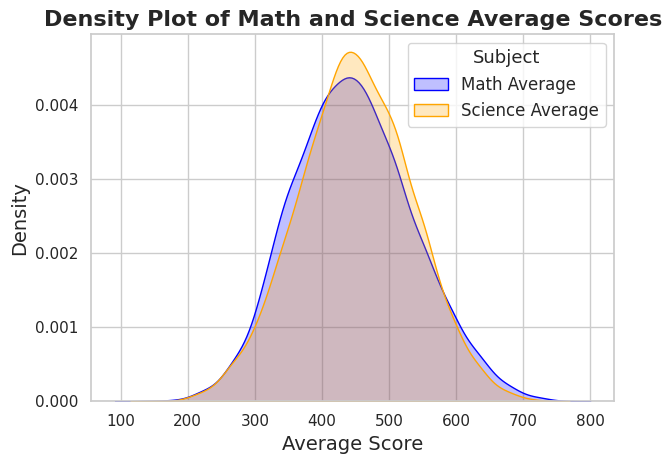

In [ ]:

# Set a whitegrid style for the plot
sns.set(style="whitegrid")

# Plot the KDE for Math and Science average scores with orange and blue colors
sns.kdeplot(stud_ach['math_avg'], color='blue', label='Math Average', fill=True)
sns.kdeplot(stud_ach['science_avg'], color='orange', label='Science Average', fill=True)

# Customize titles and labels
plt.title('Density Plot of Math and Science Average Scores', fontsize=16, fontweight='bold')
plt.xlabel('Average Score', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Customize legend
plt.legend(title='Subject', title_fontsize='13', fontsize='12')

# Adjust layout to avoid clipping of labels and title
plt.tight_layout()

# Display the plot
plt.show()

<ipython-input-115-ac0097e3d2a9>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(x='Gender', data=student_filtered_ach, palette='muted')
<ipython-input-115-ac0097e3d2a9>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Girl', 'Boy'])


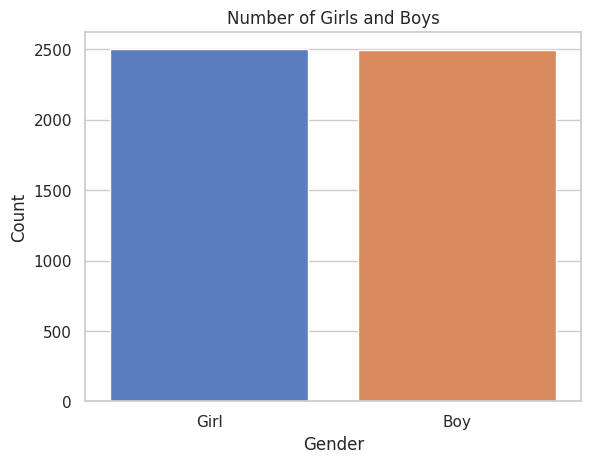

In [ ]:
ax=sns.countplot(x='Gender', data=student_filtered_ach, palette='muted')
plt.title('Number of Girls and Boys')
# Set custom labels for the x-axis
ax.set_xticklabels(['Girl', 'Boy'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


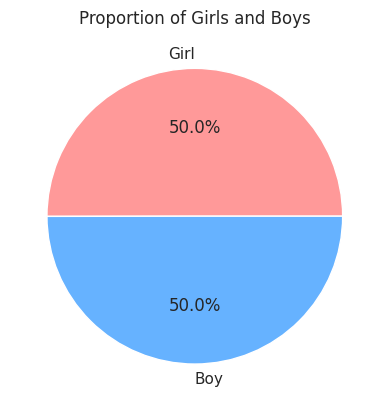

In [ ]:

# Assuming 'student_filtered_ach' is your dataframe
gender_counts = student_filtered_ach['Gender'].value_counts()

# Plotting the pie chart with custom labels
gender_counts.plot.pie(
    labels=['Boy' if i == 1 else 'Girl' for i in gender_counts.index],
    autopct='%1.1f%%',
    colors=['#FF9999', '#66B2FF']
)

plt.title('Proportion of Girls and Boys')
plt.ylabel('')  # Hide the y-label
plt.show()


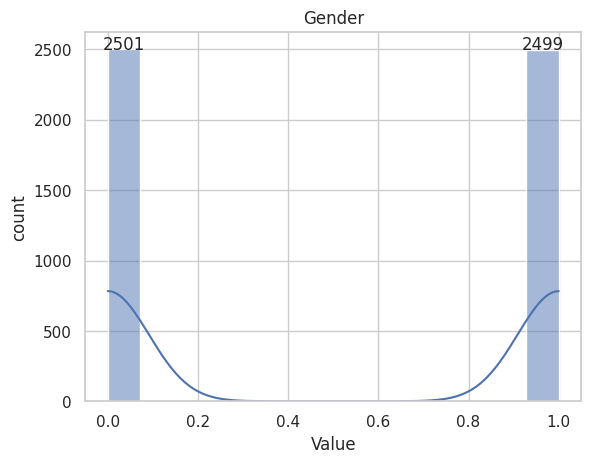

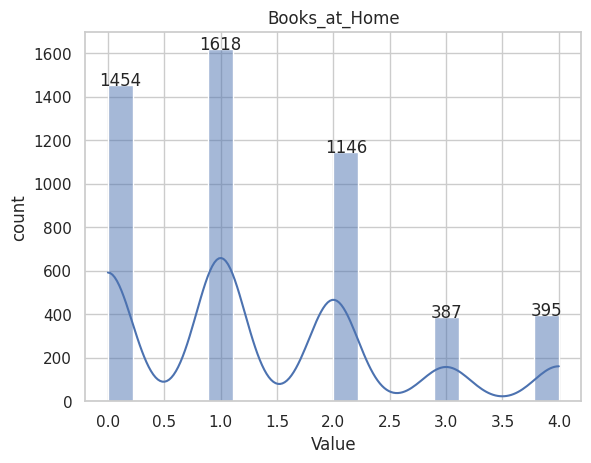

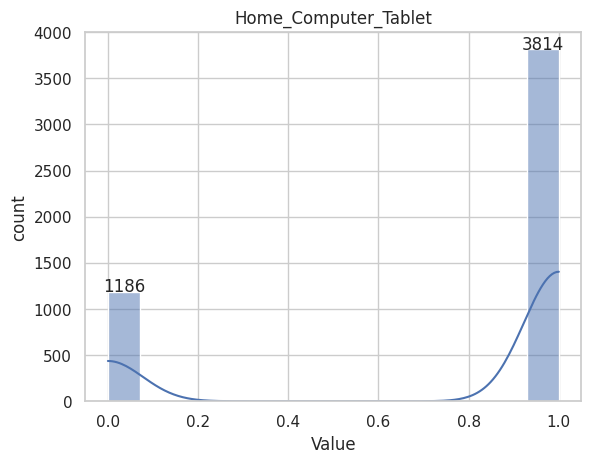

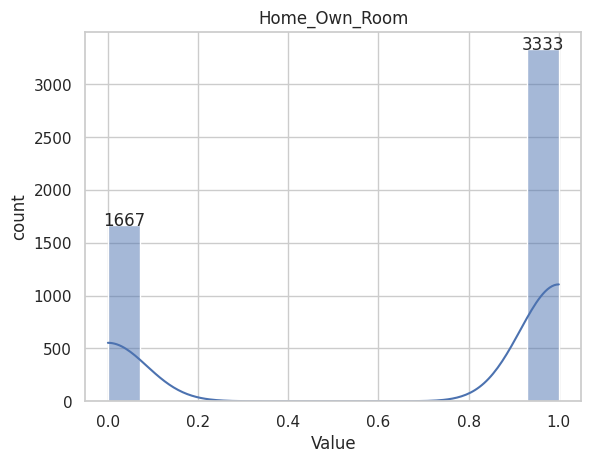

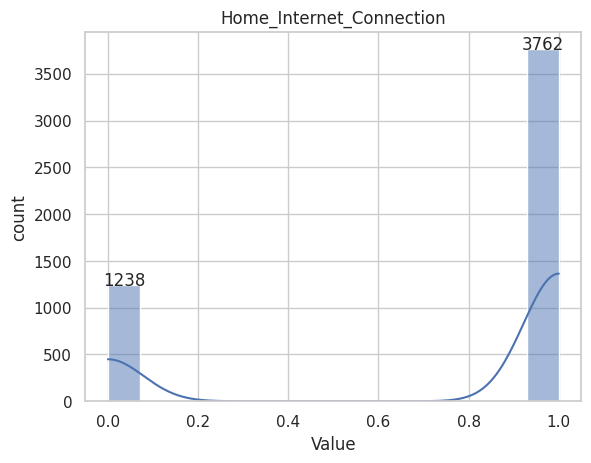

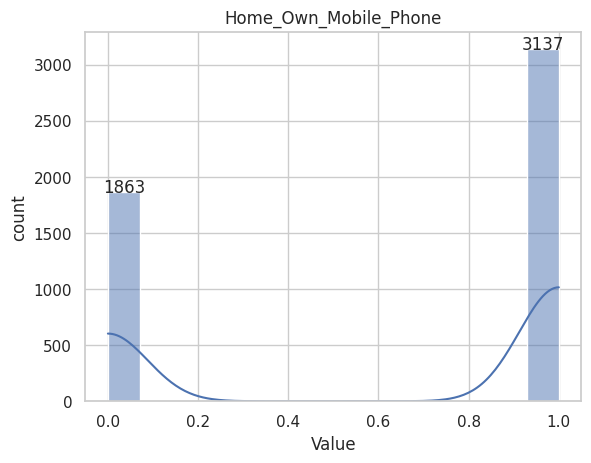

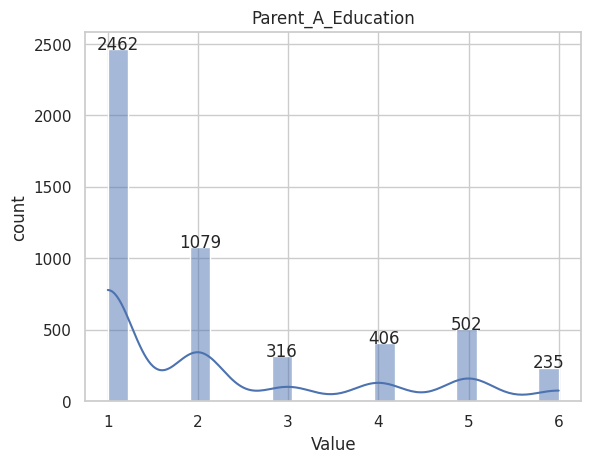

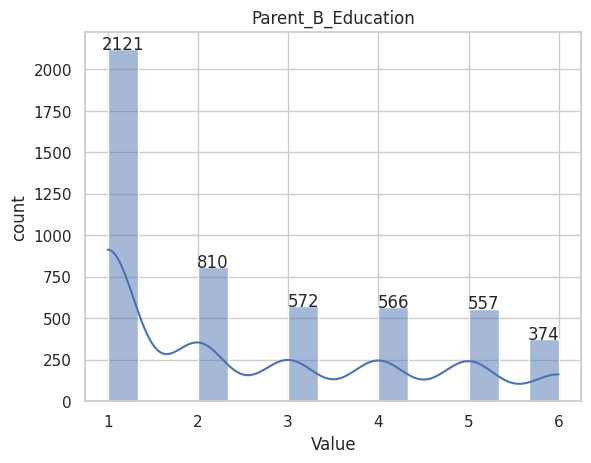

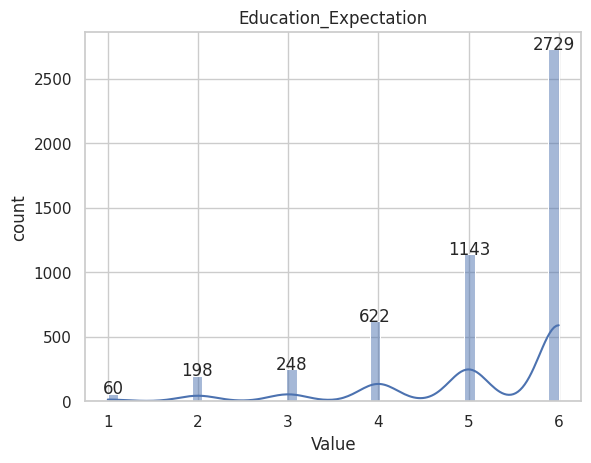

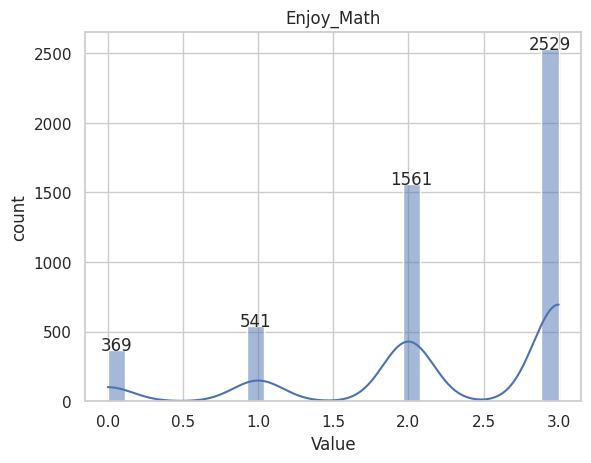

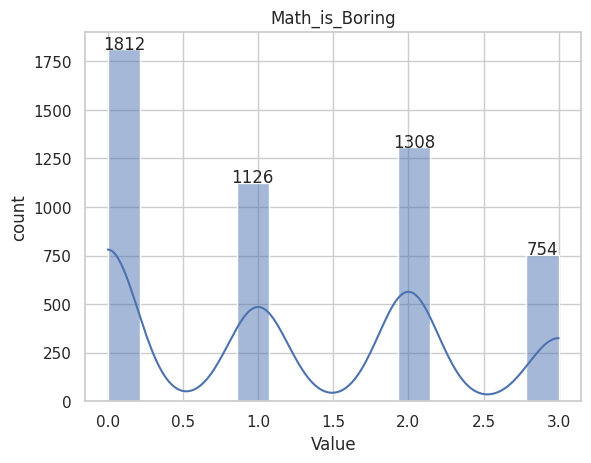

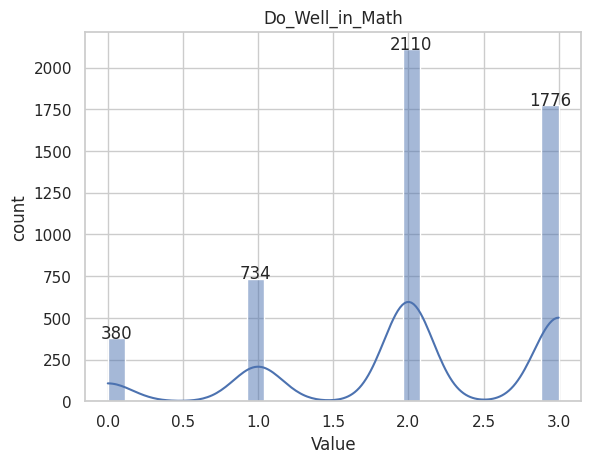

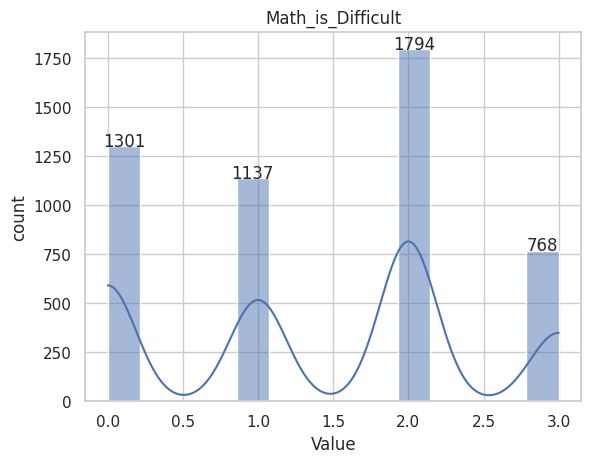

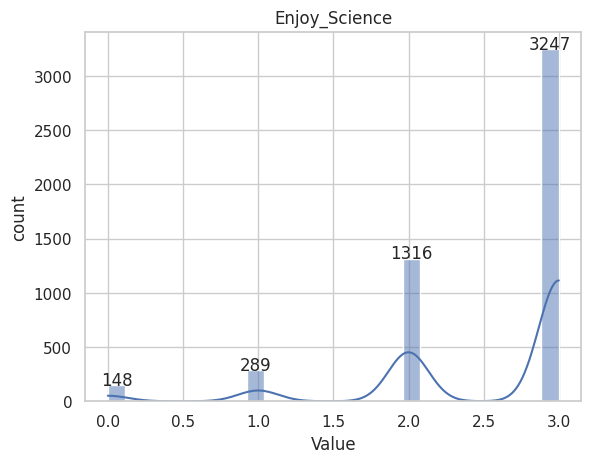

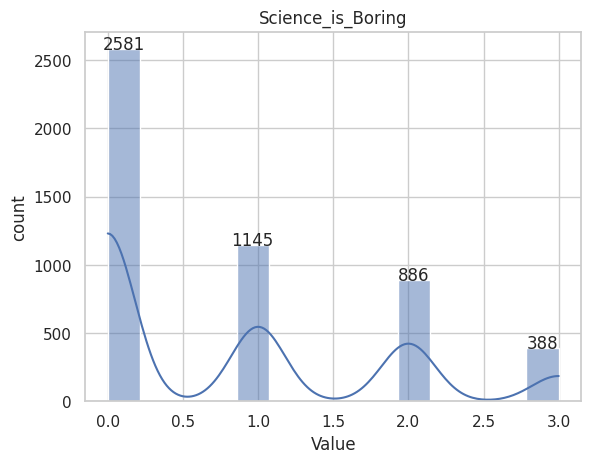

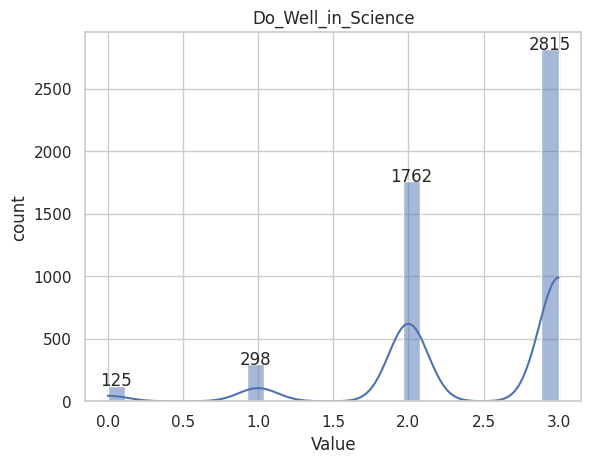

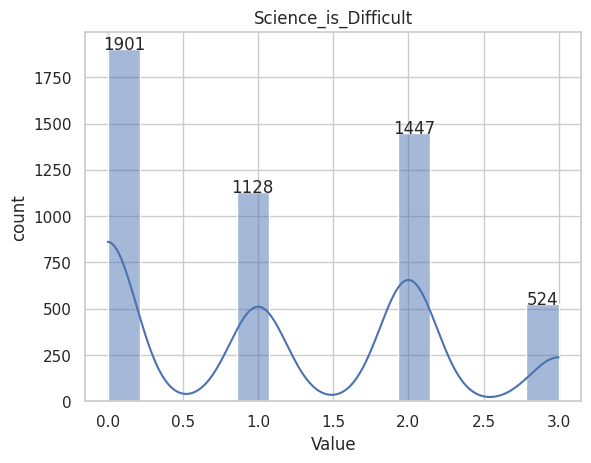

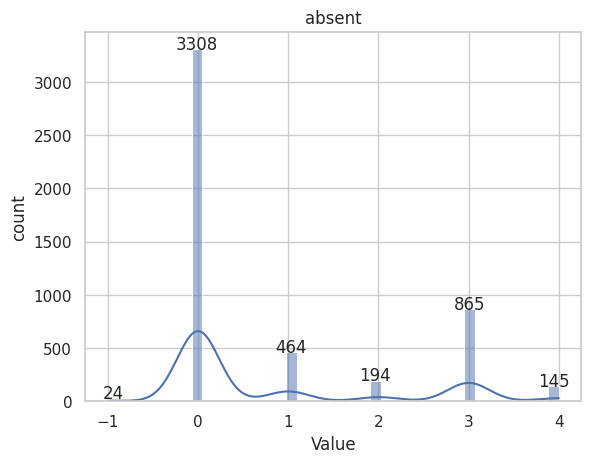

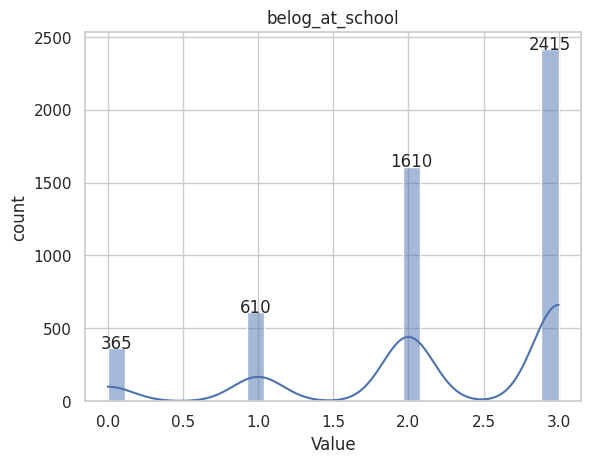

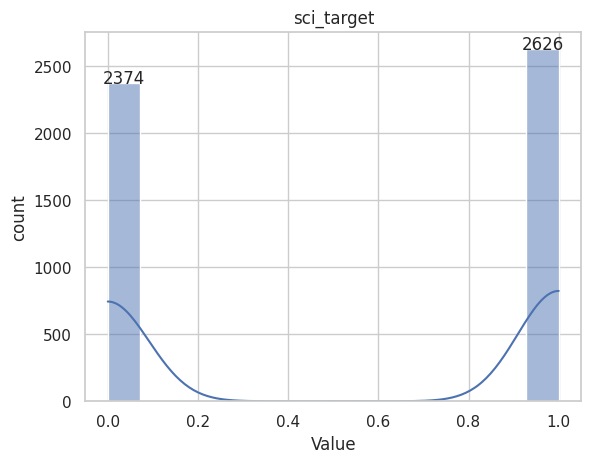

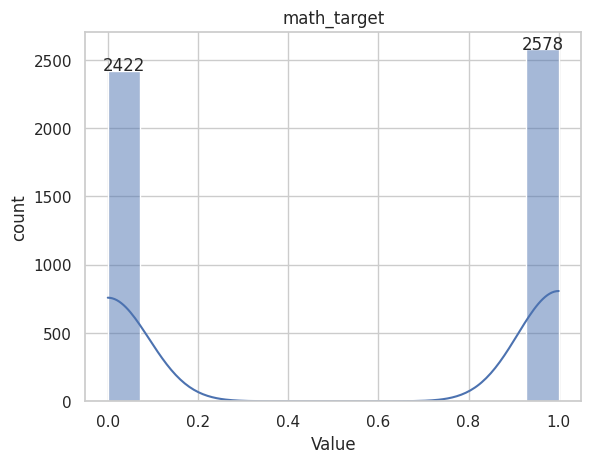

In [ ]:
filtered_columns=['Gender','Books_at_Home', 'Home_Computer_Tablet','Home_Own_Room', 'Home_Internet_Connection', 'Home_Own_Mobile_Phone' ,'Parent_A_Education', 'Parent_B_Education', 'Education_Expectation', 'Enjoy_Math', 'Math_is_Boring', 'Do_Well_in_Math', 'Math_is_Difficult','Enjoy_Science', 'Science_is_Boring', 'Do_Well_in_Science',  'Science_is_Difficult', 'absent', 'belog_at_school','sci_target', 'math_target']
for column in filtered_columns:
    ax=sns.histplot(student_filtered_ach[column], kde=True)
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('count')

    # Annotate the counts, filtering out zero counts
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    plt.show()




<Figure size 2000x2000 with 0 Axes>

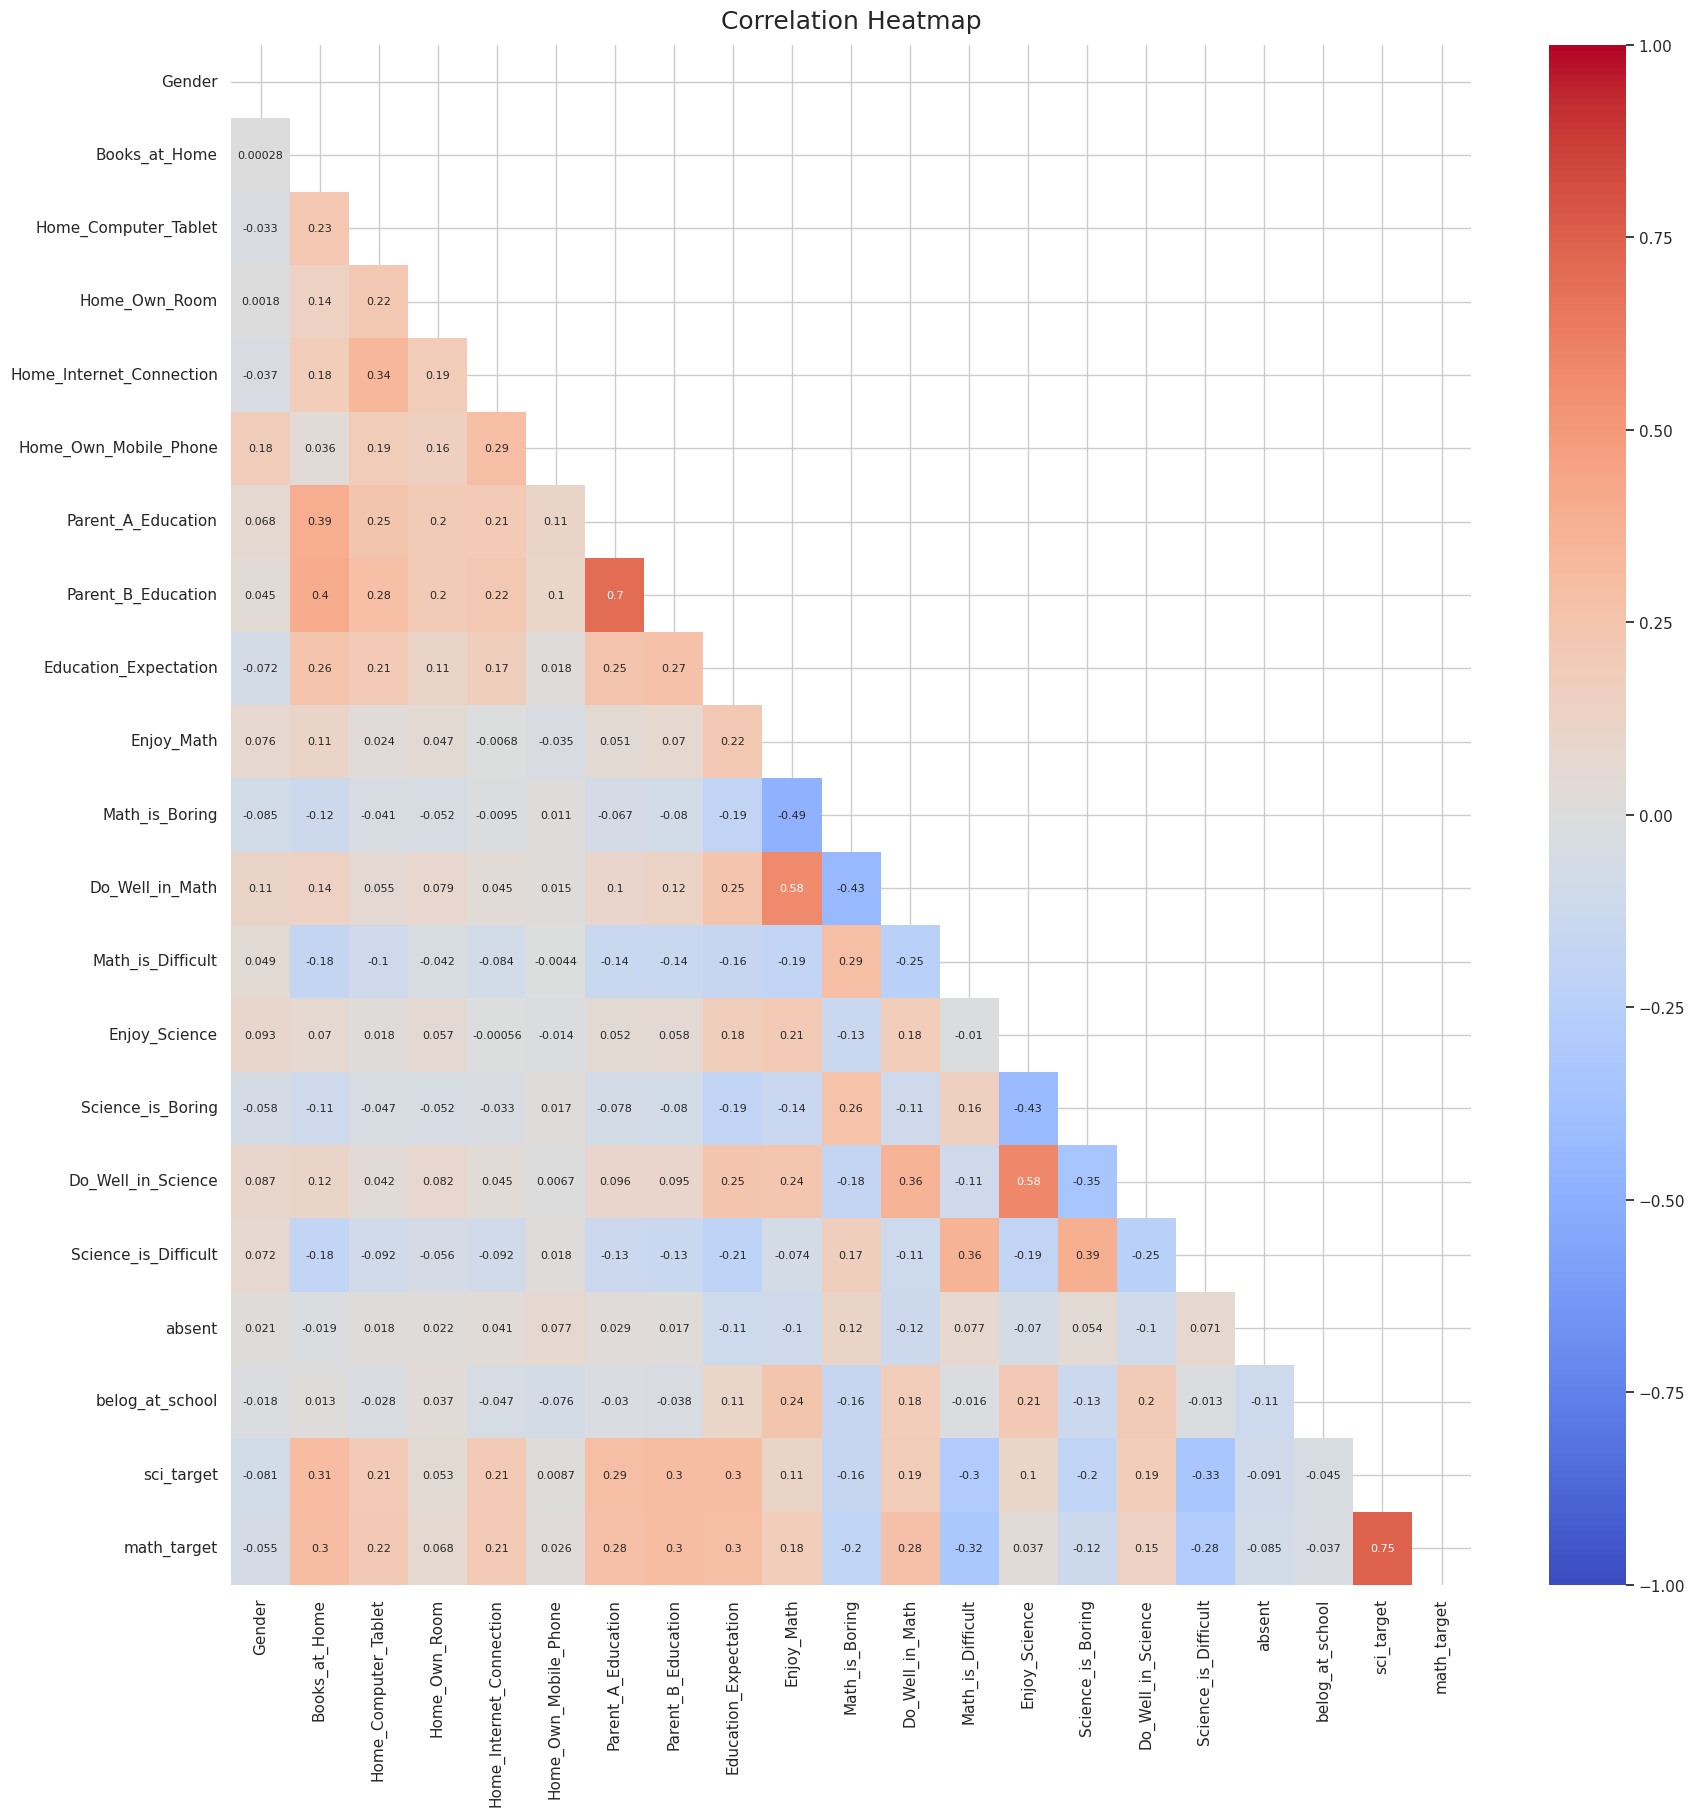

In [ ]:
plt.figure(figsize=(20, 20))
delete_columns=['Country_ID','School_ID', 'Class_ID','Student_ID']
student_filtered_ach_filtered_ID=student_filtered_ach.copy()
student_filtered_ach_filtered=student_filtered_ach.drop(delete_columns, axis=1)
corr_matrix=student_filtered_ach_filtered.corr()
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 20))
heatmap =sns.heatmap(corr_matrix,vmin=-1, vmax=1, annot=True,cmap=sns.color_palette("coolwarm", as_cmap=True),annot_kws={"size": 8}, mask=mask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.show()

# Feature selection methods for student_filtered_ach_filtered

## filter methods

In [ ]:


X=student_filtered_ach_filtered[['Gender', 'Books_at_Home', 'Home_Computer_Tablet', 'Home_Own_Room',
       'Home_Internet_Connection', 'Home_Own_Mobile_Phone',
       'Parent_A_Education', 'Parent_B_Education', 'Education_Expectation',
       'Enjoy_Math', 'Math_is_Boring', 'Do_Well_in_Math', 'Math_is_Difficult',
       'Enjoy_Science', 'Science_is_Boring', 'Do_Well_in_Science',
       'Science_is_Difficult', 'absent', 'belog_at_school']]

y=student_filtered_ach_filtered[['math_target','sci_target']]



###ANOVA

In [ ]:
pip install statsmodels

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
student_filtered_ach_filtered

,Gender,Books_at_Home,Home_Computer_Tablet,Home_Own_Room,Home_Internet_Connection,Home_Own_Mobile_Phone,Parent_A_Education,Parent_B_Education,Education_Expectation,Enjoy_Math,Math_is_Boring,Do_Well_in_Math,Math_is_Difficult,Enjoy_Science,Science_is_Boring,Do_Well_in_Science,Science_is_Difficult,absent,belog_at_school,sci_target,math_target
1,0.0,4.0,1.0,1.0,1.0,1.0,5.0,5.0,6,2.0,2.0,2.0,0.0,2.0,1.0,3.0,1.0,2,0.0,1,1
2,0.0,4.0,1.0,1.0,1.0,1.0,6.0,6.0,5,0.0,3.0,0.0,3.0,3.0,0.0,2.0,1.0,2,0.0,0,0
3,0.0,2.0,1.0,0.0,1.0,1.0,3.0,3.0,5,1.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,1,1.0,1,1
4,0.0,2.0,1.0,1.0,1.0,1.0,6.0,6.0,6,3.0,1.0,3.0,0.0,2.0,2.0,2.0,2.0,3,2.0,0,1
5,0.0,4.0,1.0,1.0,1.0,0.0,5.0,5.0,5,2.0,2.0,1.0,2.0,2.0,3.0,2.0,1.0,1,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5974,1.0,1.0,0.0,1.0,0.0,0.0,4.0,3.0,6,2.0,2.0,2.0,1.0,2.0,1.0,3.0,1.0,0,1.0,0,0
5976,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,6,3.0,0.0,3.0,0.0,2.0,0.0,3.0,0.0,0,3.0,1,1
5977,1.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,4,3.0,2.0,1.0,2.0,3.0,0.0,2.0,1.0,0,1.0,0,0
5978,1.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,6,1.0,1.0,3.0,1.0,3.0,1.0,3.0,1.0,0,2.0,1,1


###Chi-Square Test

###Fisher Score

## Wrapper methods

### Forward selection

### backward elimination

### recursive Feature elimination(RFE)

Based on the configuartion matirx, we adjust the number of features to select to be 10(based on the number of features with corrolation more that 0.2 for each of target variables is 10)
Then we use three classification algorithm along with RFE which are:

* logistic regression
* decition tree
* svm

**Math**

In [ ]:
# explore the algorithm wrapped by RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score



# get the dataset


# get a list of models to evaluate
def get_models(X, y, n_features_to_select=10):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	# lr
  rfe = RFE(estimator=LogisticRegression(), n_features_to_select=n_features_to_select)
  # fit RFE
  rfe.fit(X_train, y_train)
  # summarize all features
  print('logistic regression')
  y_pred = rfe.predict(X_test)
  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1 Score: {f1:.2f}')
  for i in range(X.shape[1]):
    if rfe.support_[i]:
      print(f'column {X.columns[i]}, {rfe.ranking_[i]}')
  print('------------------')



	# cart
  rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n_features_to_select)
  # fit RFE
  rfe.fit(X_train, y_train)
  # summarize all features
  print('decision tree')
  y_pred = rfe.predict(X_test)
  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1 Score: {f1:.2f}')
  for i in range(X.shape[1]):
    if rfe.support_[i]:
      print(f'column {X.columns[i]}, {rfe.ranking_[i]}')
  print('------------------')

	# rf
  rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=n_features_to_select)
  # fit RFE
  rfe.fit(X_train, y_train)
  # summarize all features
  print('random forest')
  y_pred = rfe.predict(X_test)
  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1 Score: {f1:.2f}')
  for i in range(X.shape[1]):
    if rfe.support_[i]:
      print(f'column {X.columns[i]}, {rfe.ranking_[i]}')
  print('------------------')


	# gbm
  rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=n_features_to_select)
  # fit RFE
  rfe.fit(X_train, y_train)
  # summarize all features
  print('gradient bossting')
  y_pred = rfe.predict(X_test)
  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1 Score: {f1:.2f}')
  for i in range(X.shape[1]):
    if rfe.support_[i]:
      print(f'column {X.columns[i]}, {rfe.ranking_[i]}')
  print('------------------')

In [ ]:
# get the models to evaluate
get_models(X, y['math_target'],10)

logistic regression
Accuracy: 0.74
Precision: 0.74
Recall: 0.75
F1 Score: 0.74
column Books_at_Home, 1
column Home_Computer_Tablet, 1
column Home_Own_Room, 1
column Home_Internet_Connection, 1
column Home_Own_Mobile_Phone, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column belog_at_school, 1
------------------
decision tree
Accuracy: 0.64
Precision: 0.66
Recall: 0.61
F1 Score: 0.63
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Math_is_Boring, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Boring, 1
column Science_is_Difficult, 1
column belog_at_school, 1
------------------
random forest
Accuracy: 0.73
Precision: 0.73
Recall: 0.74
F1 Score: 0.74
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Math_is_Boring, 1
column Do_Well_in_Math, 1
colum

**Science**

In [ ]:
# get the models to evaluate
get_models(X, y['sci_target'],10)

logistic regression
Accuracy: 0.74
Precision: 0.73
Recall: 0.76
F1 Score: 0.75
column Gender, 1
column Books_at_Home, 1
column Home_Computer_Tablet, 1
column Home_Own_Room, 1
column Home_Internet_Connection, 1
column Home_Own_Mobile_Phone, 1
column Parent_A_Education, 1
column Education_Expectation, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
------------------
decision tree
Accuracy: 0.63
Precision: 0.64
Recall: 0.63
F1 Score: 0.63
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Enjoy_Math, 1
column Math_is_Boring, 1
column Math_is_Difficult, 1
column Science_is_Boring, 1
column Science_is_Difficult, 1
column belog_at_school, 1
------------------
random forest
Accuracy: 0.72
Precision: 0.73
Recall: 0.74
F1 Score: 0.73
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Math_is_Boring, 1
column Do_Well_in_Math, 1
column Math_is_D

## Embedded methods

### Regularization

#### l1

#####math

In [ ]:
model = LogisticRegression(penalty='l1', solver='liblinear', C=0.01)
model.fit(X_train, y_train['math_target'])
y_pred = model.predict(X_test)

print(classification_report(y_test['math_target'],y_pred,labels=[0, 1]))
cf_matrix=confusion_matrix(y_test['math_target'], y_pred)
sns.heatmap(cf_matrix,cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True)

NameError: name 'X_train' is not defined

##### science

In [ ]:
model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
model.fit(X_train, y_train['sci_target'])
y_pred = model.predict(X_test)

print(classification_report(y_test['sci_target'],y_pred,labels=[0, 1]))
cf_matrix=confusion_matrix(y_test['sci_target'], y_pred)
sns.heatmap(cf_matrix,cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True)

#### l2

##### math

In [ ]:
model = LogisticRegression(penalty='l2', solver='liblinear', C=1000)
model.fit(X_train, y_train['math_target'])
y_pred = model.predict(X_test)

print(classification_report(y_test['math_target'],y_pred,labels=[0, 1]))
cf_matrix=confusion_matrix(y_test['math_target'], y_pred)
sns.heatmap(cf_matrix,cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True)

##### science

In [ ]:
model = LogisticRegression(penalty='l2', solver='liblinear', C=1.0)
model.fit(X_train, y_train['sci_target'])
y_pred = model.predict(X_test)

print(classification_report(y_test['sci_target'],y_pred,labels=[0, 1]))
cf_matrix=confusion_matrix(y_test['sci_target'], y_pred)
sns.heatmap(cf_matrix,cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True)

### Random Forests

#### math

In [ ]:

rfc = RandomForestClassifier(n_estimators = 10000)

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
rfc.fit(X_train, y_train['math_target'])

# performing predictions on the test dataset
y_pred = rfc.predict(X_test)

#reports
print(classification_report(y_test['math_target'],y_pred,labels=[0, 1]))
cf_matrix=confusion_matrix(y_test['math_target'], y_pred)
sns.heatmap(cf_matrix,cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True)


In [ ]:
#extract feature importances
importances = rfc.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)


#### science

In [ ]:

rfc = RandomForestClassifier(n_estimators = 100)

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
rfc.fit(X_train, y_train['sci_target'])

# performing predictions on the test dataset
y_pred = rfc.predict(X_test)

#reports
print(classification_report(y_test['sci_target'],y_pred,labels=[0, 1]))
cf_matrix=confusion_matrix(y_test['sci_target'], y_pred)
sns.heatmap(cf_matrix,cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True)


In [ ]:
#extract feature importances
importances = rfc.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)


###svm

#### math

##### linear

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
svmc = svm.SVC(C=1.0, kernel='linear') # Linear Kernel

#Train the model using the training sets
svmc.fit(X_train, y_train['math_target'])

#Predict the response for test dataset
y_pred = svmc.predict(X_test)
print(classification_report(y_test['math_target'],y_pred,labels=[0, 1]))
cf_matrix=confusion_matrix(y_test['math_target'], y_pred)
sns.heatmap(cf_matrix,cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True)

##### rbf

In [ ]:
#Create a svm Classifier
svmc = svm.SVC(C=1.0, kernel='rbf') # Linear Kernel

#Train the model using the training sets
svmc.fit(X_train, y_train['math_target'])

#Predict the response for test dataset
y_pred = svmc.predict(X_test)
print(classification_report(y_test['math_target'],y_pred,labels=[0, 1]))
cf_matrix=confusion_matrix(y_test['math_target'], y_pred)
sns.heatmap(cf_matrix,cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True)

#### science

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
svmc = svm.SVC(C=1.0, kernel='linear') # Linear Kernel

#Train the model using the training sets
svmc.fit(X_train, y_train['sci_target'])

#Predict the response for test dataset
y_pred = svmc.predict(X_test)
print(classification_report(y_test['sci_target'],y_pred,labels=[0, 1]))
cf_matrix=confusion_matrix(y_test['sci_target'], y_pred)
sns.heatmap(cf_matrix,cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True)

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
svmc = svm.SVC(C=0.1, kernel='rbf') # Linear Kernel

#Train the model using the training sets
svmc.fit(X_train, y_train['sci_target'])

#Predict the response for test dataset
y_pred = svmc.predict(X_test)
print(classification_report(y_test['sci_target'],y_pred,labels=[0, 1]))
cf_matrix=confusion_matrix(y_test['sci_target'], y_pred)
sns.heatmap(cf_matrix,cmap=sns.color_palette("coolwarm", as_cmap=True), annot=True)

# Data preprocessiong and Feature selection methods for teacher_ach_filtered

##math teacher

In [ ]:
math_teach_filtered=math_teach_filtered.replace({'Yes': 1, 'No': 0})

In [ ]:
math_teach_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   IDCNTRY                            220 non-null    float64
 1   IDSCHOOL                           220 non-null    float64
 2   IDTEACH                            220 non-null    float64
 3   Years_Teaching                     220 non-null    float64
 4   Education_Level_Completed          219 non-null    object 
 5   Major_Mathematics                  219 non-null    float64
 6   Major_Biology                      220 non-null    int64  
 7   Major_Physics                      220 non-null    int64  
 8   Major_Chemistry                    220 non-null    int64  
 9   Major_Earth_Science                219 non-null    float64
 10  Major_Edu_Mathematics              220 non-null    int64  
 11  Major_Edu_Science                  220 non-null    int64  

In [ ]:
for column in math_teach_filtered.columns:
    unique_values = math_teach_filtered[column].unique()
    print(f"Unique values in '{column}': {unique_values}\n")

Unique values in 'IDCNTRY': [364.]

Unique values in 'IDSCHOOL': [5001. 5002. 5003. 5004. 5005. 5006. 5007. 5008. 5009. 5010. 5011. 5012.
 5013. 5014. 5015. 5016. 5017. 5018. 5019. 5020. 5021. 5022. 5023. 5024.
 5025. 5026. 5027. 5028. 5029. 5030. 5031. 5032. 5033. 5034. 5035. 5036.
 5037. 5038. 5039. 5040. 5041. 5042. 5043. 5044. 5045. 5046. 5047. 5048.
 5049. 5050. 5051. 5052. 5053. 5054. 5055. 5056. 5057. 5058. 5059. 5060.
 5061. 5062. 5063. 5064. 5065. 5066. 5067. 5068. 5069. 5070. 5071. 5072.
 5073. 5074. 5075. 5076. 5077. 5078. 5079. 5080. 5081. 5082. 5083. 5084.
 5085. 5086. 5087. 5088. 5089. 5090. 5091. 5092. 5093. 5094. 5095. 5096.
 5097. 5098. 5099. 5100. 5101. 5102. 5103. 5104. 5105. 5106. 5107. 5108.
 5109. 5110. 5111. 5112. 5113. 5114. 5115. 5116. 5117. 5118. 5119. 5120.
 5121. 5122. 5123. 5124. 5125. 5126. 5127. 5128. 5129. 5130. 5131. 5132.
 5133. 5134. 5135. 5136. 5137. 5138. 5139. 5140. 5141. 5142. 5143. 5144.
 5145. 5146. 5147. 5148. 5149. 5150. 5151. 5152. 5153. 5154

In [ ]:
mapping = {
    'Never': 0,
    'Some lessons': 1,
    'About half the lessons': 2,
    'Every or almost every lesson': 3
}

columns_to_replace=math_teach_filtered.filter(like='Ask').columns
math_teach_filtered[columns_to_replace] = math_teach_filtered[columns_to_replace].replace(mapping)

In [ ]:
def standardize_education(level):
    if pd.isna(level) or level == "Not applicable":
        return np.nan
    elif "I don’t know" in level:
        return np.nan
    elif "Postgraduate" in level or "Master" in level or "Doctor" in level:
        return 6
    elif "Bachelor" in level:
        return 5
    elif "Upper secondary" in level:
        return 2
    elif "Lower secondary" in level:
        return 1
    elif "Short-cycle tertiary" in level:
        return 4
    elif "Post-secondary" in level:
        return 3
    elif "Primary" in level or "did not go to school" in level:
        return 0
    else:
        return np.nan



math_teach_filtered['Education_Level_Completed']=math_teach_filtered['Education_Level_Completed'].apply(standardize_education)



In [ ]:
mapping = {
    '3 or 4 times a week': 3,
    '1 or 2 times a week': 2,
    'I do not assign mathematics homework': 0,
    'Less than once a week': 1,
    'Every day':5
}

columns_to_replace=['Homework_Assigned_Frequency']
math_teach_filtered[columns_to_replace] = math_teach_filtered[columns_to_replace].replace(mapping)

In [ ]:
mapping={
    '31–60 minutes':2,
    '61–90 minutes':3,
    '16–30 minutes':1,
    '15 minutes or less':0,
    'More than 90 minutes':4
}
columns_to_replace=['Time_Spent_on_Homework']
math_teach_filtered[columns_to_replace] = math_teach_filtered[columns_to_replace].replace(mapping)

In [ ]:


# Step 1: Merge stud_teach_filtered with stud_math
merged_df1 = pd.merge(stud_teach_filtered, math_teach_filtered, on=['IDCNTRY', 'IDSCHOOL', 'IDTEACH'])

# Step 2: Merge the resulting DataFrame with student_filtered_ach
math_teacher_student_ach = pd.merge(merged_df1, student_filtered_ach[['Country_ID', 'School_ID', 'Student_ID', 'math_target']],  left_on=['IDCNTRY', 'IDSCHOOL', 'IDSTUD'], right_on=['Country_ID', 'School_ID', 'Student_ID'])

math_teacher_student_ach_ID=math_teacher_student_ach.copy()
math_teacher_student_ach=math_teacher_student_ach.drop(columns=['Country_ID', 'School_ID', 'Student_ID'])

In [ ]:
math_teacher_student_ach.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5045 entries, 0 to 5044
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   IDCNTRY                            5045 non-null   float64
 1   IDBOOK                             5045 non-null   object 
 2   IDSCHOOL                           5045 non-null   float64
 3   IDSTUD                             5045 non-null   float64
 4   IDTEACH                            5045 non-null   float64
 5   Years_Teaching                     5045 non-null   float64
 6   Education_Level_Completed          5018 non-null   float64
 7   Major_Mathematics                  5030 non-null   float64
 8   Major_Biology                      5045 non-null   int64  
 9   Major_Physics                      5045 non-null   int64  
 10  Major_Chemistry                    5045 non-null   int64  
 11  Major_Earth_Science                5011 non-null   float

<Figure size 2000x2000 with 0 Axes>

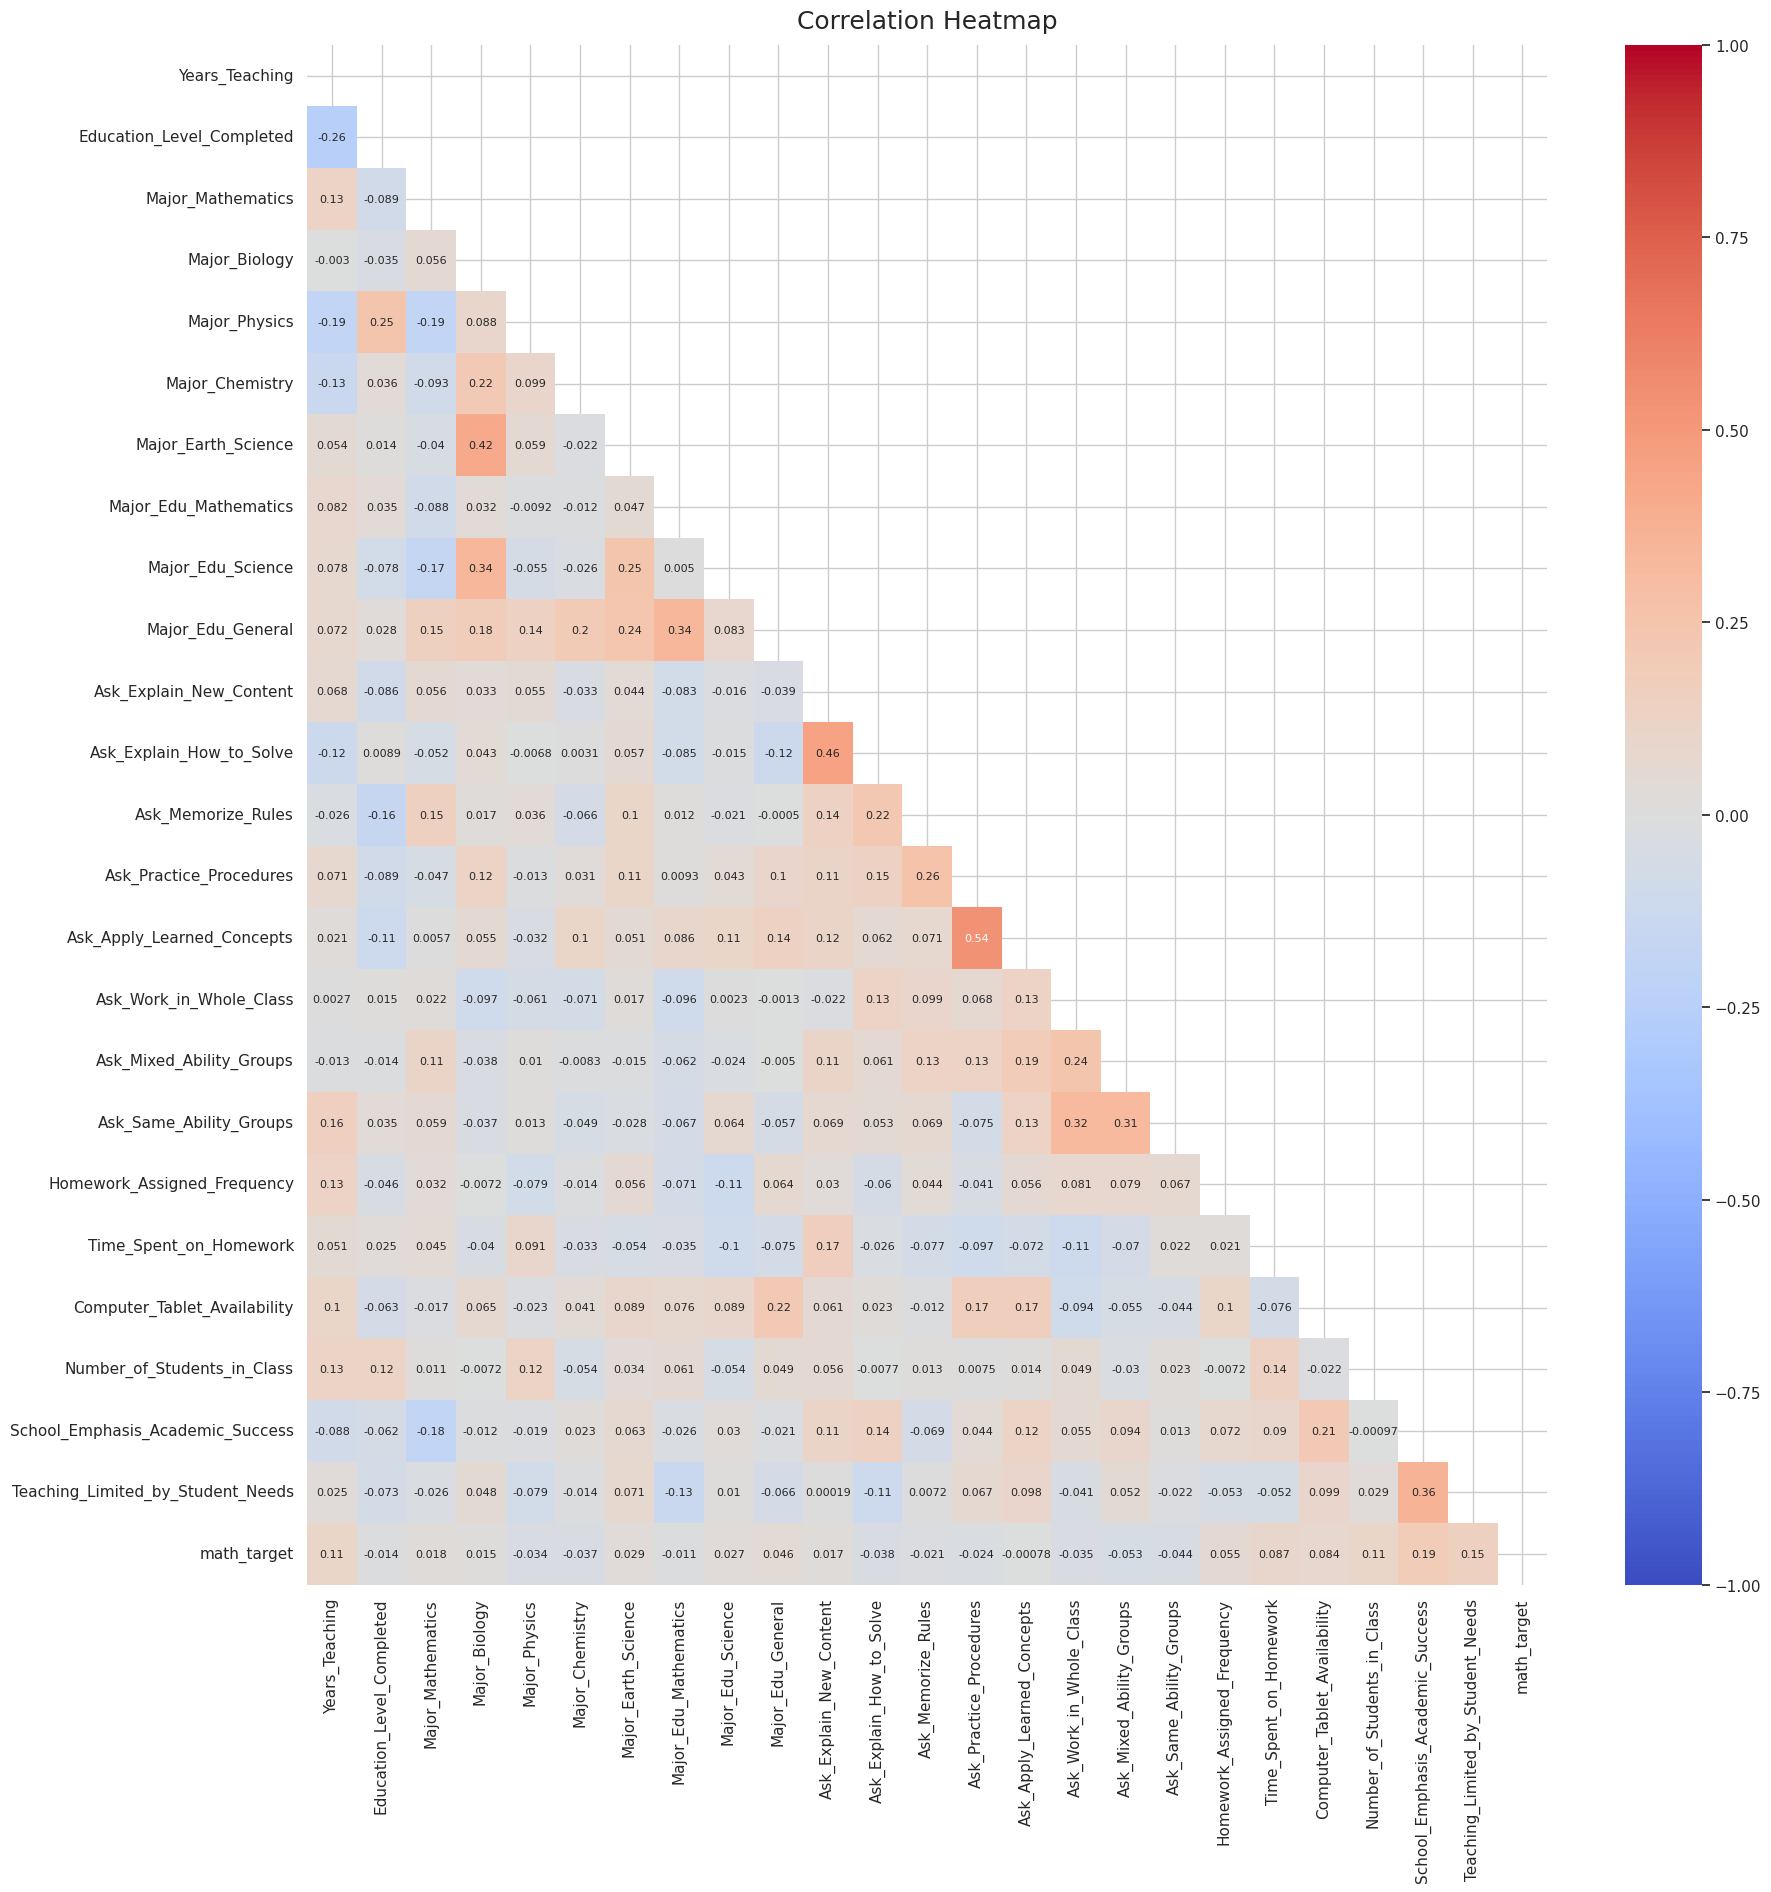

In [ ]:
plt.figure(figsize=(20, 20))
delete_columns=['IDCNTRY','IDSCHOOL', 'IDTEACH','IDSTUD','IDBOOK',]
math_teacher_student_ach=math_teacher_student_ach.drop(delete_columns, axis=1)
corr_matrix=math_teacher_student_ach.corr()
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 20))
heatmap =sns.heatmap(corr_matrix,vmin=-1, vmax=1, annot=True,cmap=sns.color_palette("coolwarm", as_cmap=True),annot_kws={"size": 8}, mask=mask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.show()


In [ ]:
corr_with_target=corr_matrix['math_target']
# Select column names with correlation greater than 0.1
threshold = 0.1

high_corr_columns = corr_with_target[corr_with_target.abs() > threshold].index.tolist()

print("Columns with correlation greater than 0.1:", high_corr_columns)

Columns with correlation greater than 0.1: ['Years_Teaching', 'Number_of_Students_in_Class', 'School_Emphasis_Academic_Success', 'Teaching_Limited_by_Student_Needs', 'math_target']


In [ ]:
math_teacher_student_ach.Time_Spent_on_Homework=math_teacher_student_ach.Time_Spent_on_Homework.fillna(0)

In [ ]:
math_teacher_student_ach=math_teacher_student_ach.dropna()
math_teacher_student_ach.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4876 entries, 0 to 5044
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Years_Teaching                     4876 non-null   float64
 1   Education_Level_Completed          4876 non-null   float64
 2   Major_Mathematics                  4876 non-null   float64
 3   Major_Biology                      4876 non-null   int64  
 4   Major_Physics                      4876 non-null   int64  
 5   Major_Chemistry                    4876 non-null   int64  
 6   Major_Earth_Science                4876 non-null   float64
 7   Major_Edu_Mathematics              4876 non-null   int64  
 8   Major_Edu_Science                  4876 non-null   int64  
 9   Major_Edu_General                  4876 non-null   int64  
 10  Ask_Explain_New_Content            4876 non-null   int64  
 11  Ask_Explain_How_to_Solve           4876 non-null   float64
 1

In [ ]:
X=math_teacher_student_ach.drop('math_target', axis=1)
y=math_teacher_student_ach['math_target']
get_models(X, y, 4)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.52
Precision: 0.58
Recall: 0.33
F1 Score: 0.43
column Major_Biology, 1
column Major_Edu_Science, 1
column Major_Edu_General, 1
column Computer_Tablet_Availability, 1
------------------
decision tree
Accuracy: 0.70
Precision: 0.74
Recall: 0.67
F1 Score: 0.71
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teaching_Limited_by_Student_Needs, 1
------------------
random forest
Accuracy: 0.70
Precision: 0.73
Recall: 0.69
F1 Score: 0.71
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teaching_Limited_by_Student_Needs, 1
------------------
gradient bossting
Accuracy: 0.67
Precision: 0.67
Recall: 0.74
F1 Score: 0.70
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teaching_Limited_by_Student_Needs, 1
------------------


##science teacher


In [ ]:
sci_teach_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 33 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   IDCNTRY                                  220 non-null    float64
 1   IDSCHOOL                                 220 non-null    float64
 2   IDTEACH                                  220 non-null    float64
 3   Years_Teaching                           220 non-null    float64
 4   Education_Level_Completed                219 non-null    object 
 5   Major_Mathematics                        217 non-null    object 
 6   Major_Biology                            218 non-null    object 
 7   Major_Physics                            217 non-null    object 
 8   Major_Chemistry                          217 non-null    object 
 9   Major_Earth_Science                      218 non-null    object 
 10  Major_Edu_Mathematics                    217 non-n

In [ ]:
for column in sci_teach_filtered.columns:
    unique_values = sci_teach_filtered[column].unique()
    print(f"Unique values in '{column}': {unique_values}\n")

Unique values in 'IDCNTRY': [364.]

Unique values in 'IDSCHOOL': [5001. 5002. 5003. 5004. 5005. 5006. 5007. 5008. 5009. 5010. 5011. 5012.
 5013. 5014. 5015. 5016. 5017. 5018. 5019. 5020. 5021. 5022. 5023. 5024.
 5025. 5026. 5027. 5028. 5029. 5030. 5031. 5032. 5033. 5034. 5035. 5036.
 5037. 5038. 5039. 5040. 5041. 5042. 5043. 5044. 5045. 5046. 5047. 5048.
 5049. 5050. 5051. 5052. 5053. 5054. 5055. 5056. 5057. 5058. 5059. 5060.
 5061. 5062. 5063. 5064. 5065. 5066. 5067. 5068. 5069. 5070. 5071. 5072.
 5073. 5074. 5075. 5076. 5077. 5078. 5079. 5080. 5081. 5082. 5083. 5084.
 5085. 5086. 5087. 5088. 5089. 5090. 5091. 5092. 5093. 5094. 5095. 5096.
 5097. 5098. 5099. 5100. 5101. 5102. 5103. 5104. 5105. 5106. 5107. 5108.
 5109. 5110. 5111. 5112. 5113. 5114. 5115. 5116. 5117. 5118. 5119. 5120.
 5121. 5122. 5123. 5124. 5125. 5126. 5127. 5128. 5129. 5130. 5131. 5132.
 5133. 5134. 5135. 5136. 5137. 5138. 5139. 5140. 5141. 5142. 5143. 5144.
 5145. 5146. 5147. 5148. 5149. 5150. 5151. 5152. 5153. 5154

In [ ]:
sci_teach_filtered=sci_teach_filtered.replace({'Yes': 1, 'No': 0})
mapping = {
    'Never': 0,
    'Some lessons': 1,
    'About half the lessons': 2,
    'Every or almost every lesson': 3
}

columns_to_replace=sci_teach_filtered.filter(like='Ask').columns
sci_teach_filtered[columns_to_replace] = sci_teach_filtered[columns_to_replace].replace(mapping)


def standardize_education(level):
    if pd.isna(level) or level == "Not applicable":
        return np.nan
    elif "I don’t know" in level:
        return np.nan
    elif "Postgraduate" in level or "Master" in level or "Doctor" in level:
        return 6
    elif "Bachelor" in level:
        return 5
    elif "Upper secondary" in level:
        return 2
    elif "Lower secondary" in level:
        return 1
    elif "Short-cycle tertiary" in level:
        return 4
    elif "Post-secondary" in level:
        return 3
    elif "Primary" in level or "did not go to school" in level:
        return 0
    else:
        return np.nan



sci_teach_filtered['Education_Level_Completed']=sci_teach_filtered['Education_Level_Completed'].apply(standardize_education)


mapping = {
    '3 or 4 times a week': 3,
    '1 or 2 times a week': 2,
    'I do not assign science homework': 0,
    'Less than once a week': 1,
    'Every day':5
}

columns_to_replace=['Frequency_Sci_Homework']
sci_teach_filtered[columns_to_replace] = sci_teach_filtered[columns_to_replace].replace(mapping)

mapping={
    '31–60 minutes':2,
    '61–90 minutes':3,
    '16–30 minutes':1,
    '15 minutes or less':0,
    'More than 90 minutes':4
}
columns_to_replace=['Time_Spent_Homework']
sci_teach_filtered[columns_to_replace] = sci_teach_filtered[columns_to_replace].replace(mapping)



# Step 1: Merge stud_teach_filtered with stud_sci
merged_df1 = pd.merge(stud_teach_filtered, sci_teach_filtered, on=['IDCNTRY', 'IDSCHOOL', 'IDTEACH'])

# Step 2: Merge the resulting DataFrame with student_filtered_ach
sci_teacher_student_ach = pd.merge(merged_df1, student_filtered_ach[['Country_ID', 'School_ID', 'Student_ID', 'sci_target']],  left_on=['IDCNTRY', 'IDSCHOOL', 'IDSTUD'], right_on=['Country_ID', 'School_ID', 'Student_ID'])

sci_teacher_student_ach_ID=sci_teacher_student_ach.copy()
sci_teacher_student_ach=sci_teacher_student_ach.drop(columns=['Country_ID', 'School_ID', 'Student_ID'])

In [ ]:
columns_to_replace=sci_teach_filtered.filter(like='Major').columns
sci_teacher_student_ach[columns_to_replace] = sci_teacher_student_ach[columns_to_replace].fillna(0)

In [ ]:
columns_to_replace=sci_teach_filtered.filter(like='Ask').columns
sci_teacher_student_ach[columns_to_replace] = sci_teacher_student_ach[columns_to_replace].fillna(0)

In [ ]:
sci_teacher_student_ach=sci_teacher_student_ach.drop(['Time_Spent_Homework', 'Frequency_Sci_Homework'], axis=1)

In [ ]:
sci_teacher_student_ach = sci_teacher_student_ach.dropna()

In [ ]:
sci_teacher_student_ach.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5011 entries, 0 to 5044
Data columns (total 34 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   IDCNTRY                                  5011 non-null   float64
 1   IDBOOK                                   5011 non-null   object 
 2   IDSCHOOL                                 5011 non-null   float64
 3   IDSTUD                                   5011 non-null   float64
 4   IDTEACH                                  5011 non-null   float64
 5   Years_Teaching                           5011 non-null   float64
 6   Education_Level_Completed                5011 non-null   float64
 7   Major_Mathematics                        5011 non-null   float64
 8   Major_Biology                            5011 non-null   float64
 9   Major_Physics                            5011 non-null   float64
 10  Major_Chemistry                          5011 non-nul

<Figure size 2000x2000 with 0 Axes>

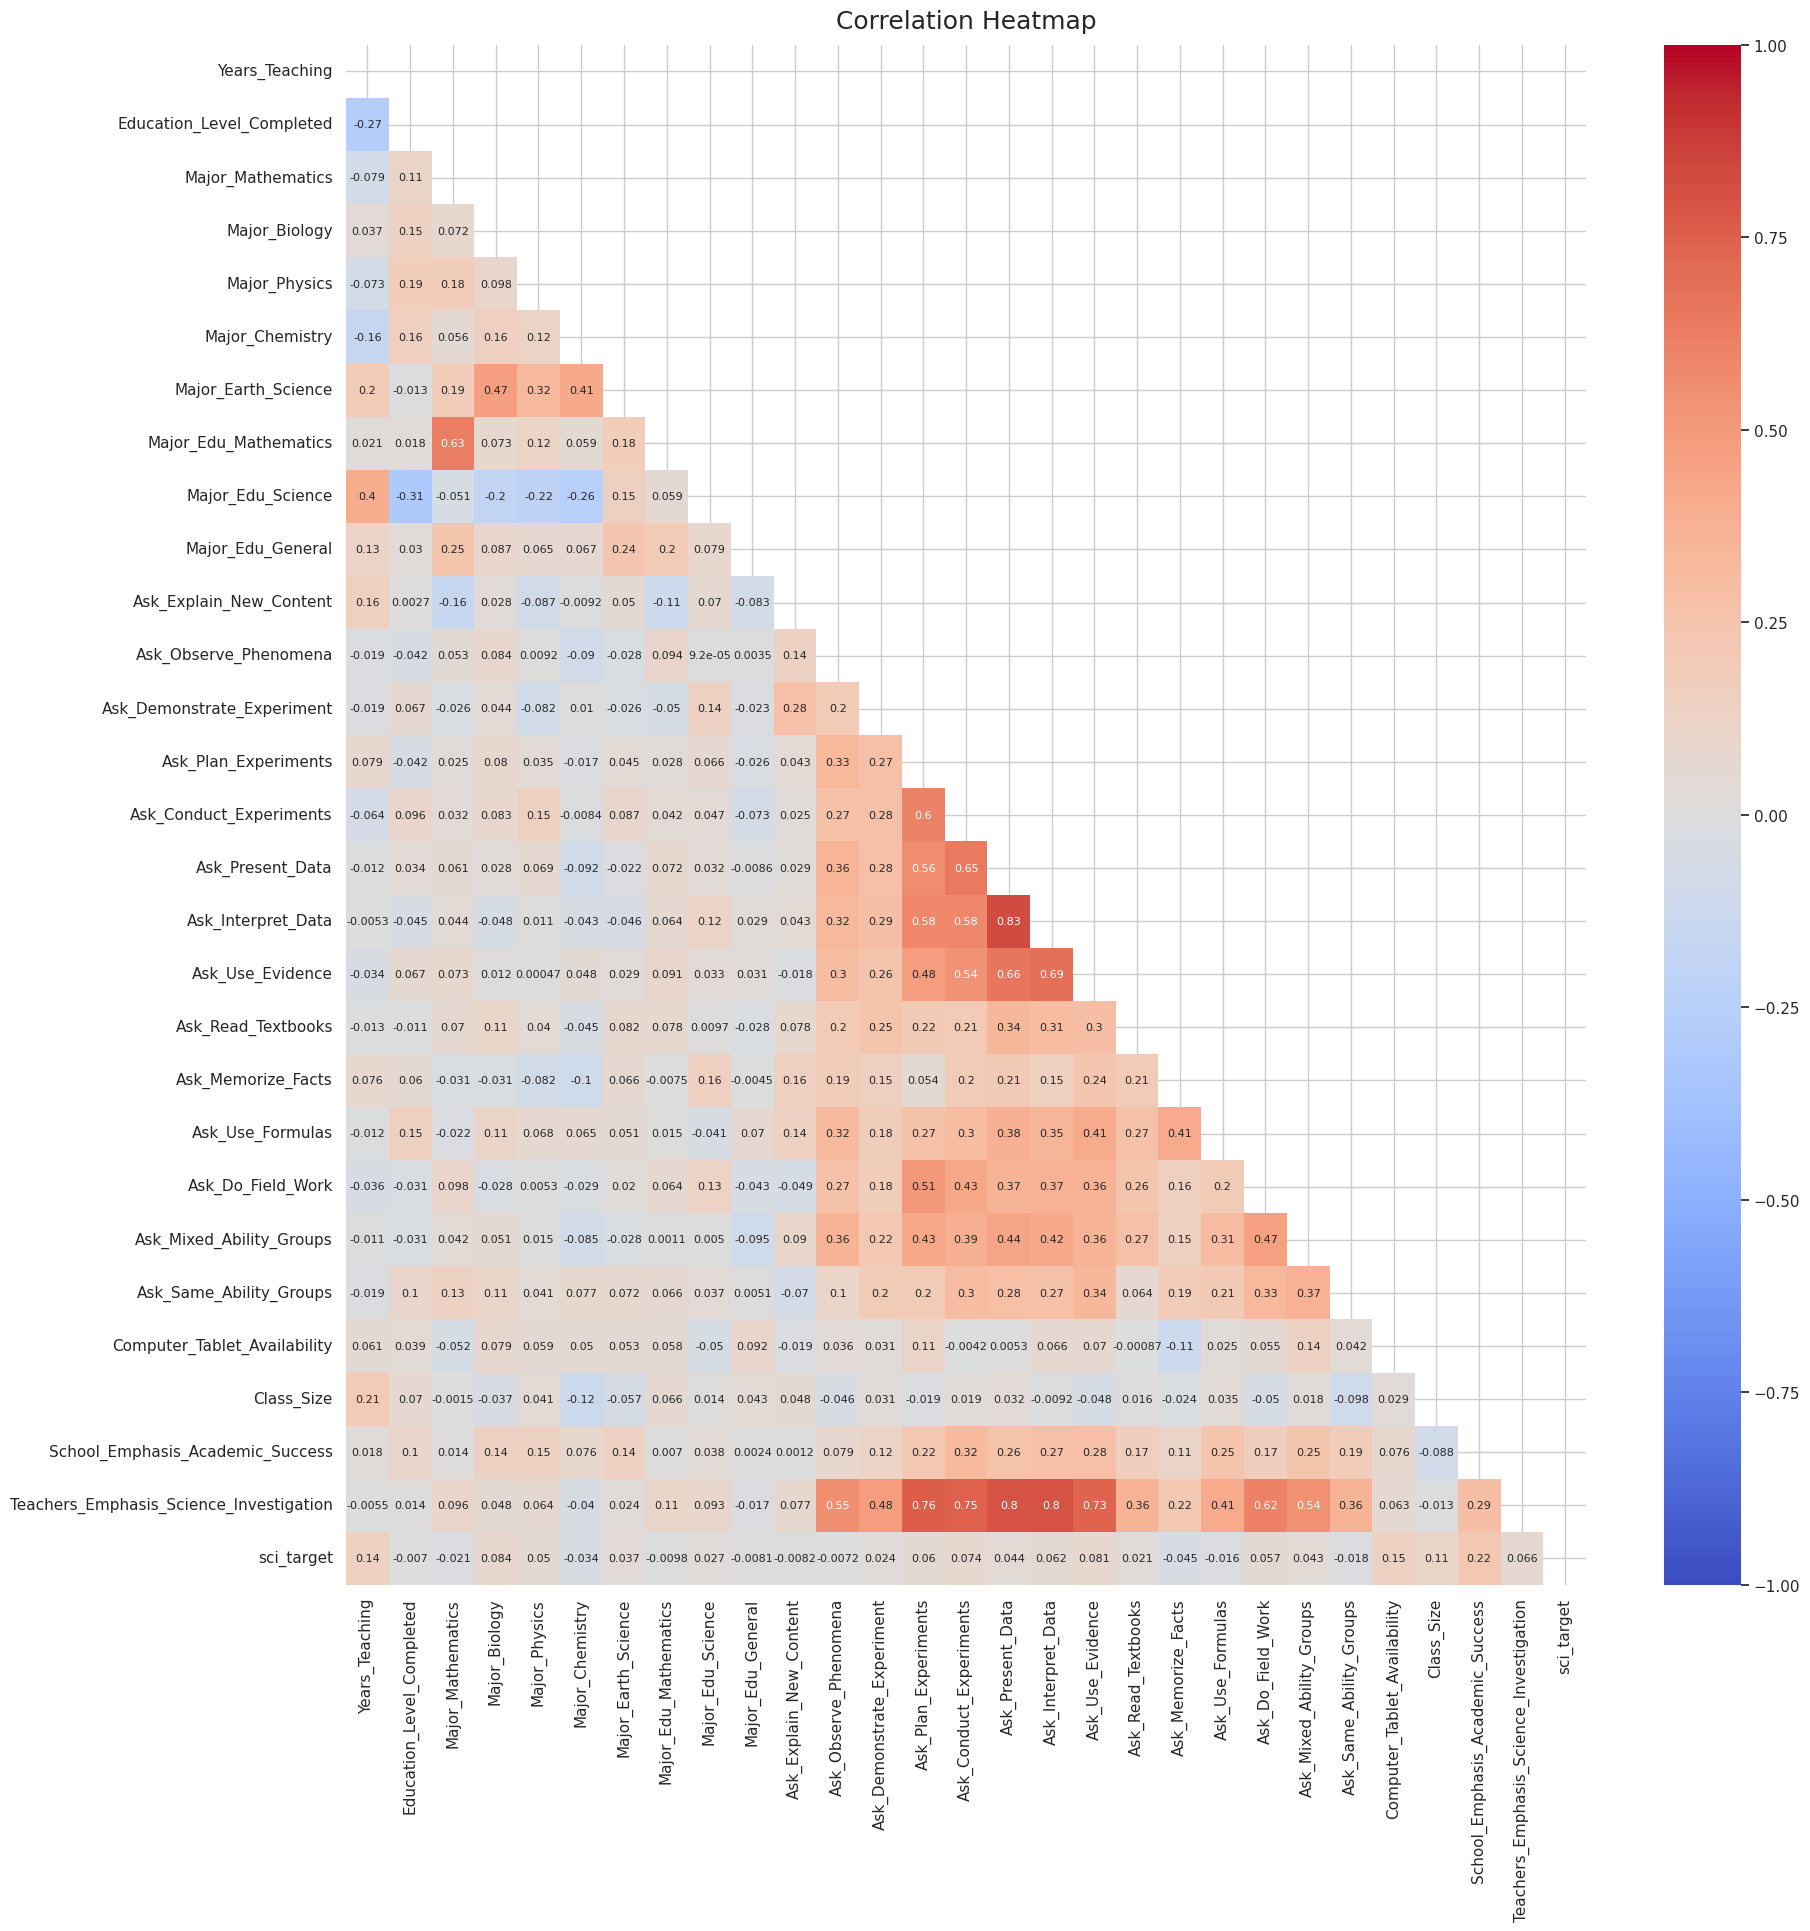

Columns with correlation greater than 0.1: ['Years_Teaching', 'Computer_Tablet_Availability', 'Class_Size', 'School_Emphasis_Academic_Success', 'sci_target']


In [ ]:
plt.figure(figsize=(20, 20))
delete_columns=['IDCNTRY','IDSCHOOL', 'IDTEACH','IDSTUD','IDBOOK',]
sci_teacher_student_ach=sci_teacher_student_ach.drop(delete_columns, axis=1)
corr_matrix=sci_teacher_student_ach.corr()
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 20))
heatmap =sns.heatmap(corr_matrix,vmin=-1, vmax=1, annot=True,cmap=sns.color_palette("coolwarm", as_cmap=True),annot_kws={"size": 8}, mask=mask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.show()

corr_with_target=corr_matrix['sci_target']
# Select column names with correlation greater than 0.1
threshold = 0.1

high_corr_columns = corr_with_target[corr_with_target.abs() > threshold].index.tolist()

print("Columns with correlation greater than 0.1:", high_corr_columns)

In [ ]:
X=sci_teacher_student_ach.drop('sci_target', axis=1)
y=sci_teacher_student_ach['sci_target']
get_models(X, y, 4)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.60
Precision: 0.60
Recall: 0.68
F1 Score: 0.64
column Major_Biology, 1
column Major_Chemistry, 1
column Major_Edu_Mathematics, 1
column Computer_Tablet_Availability, 1
------------------
decision tree
Accuracy: 0.68
Precision: 0.69
Recall: 0.69
F1 Score: 0.69
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
------------------
random forest
Accuracy: 0.68
Precision: 0.69
Recall: 0.70
F1 Score: 0.69
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
------------------
gradient bossting
Accuracy: 0.69
Precision: 0.68
Recall: 0.75
F1 Score: 0.71
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
------------------


# school

In [ ]:
# Merge the DataFrames on 'school_ID'
school_ach = pd.merge(school_filtered, stud_ach[['School_ID','Student_ID', 'math_target', 'sci_target']], on='School_ID')


In [ ]:
def column_unique_review(df):
  for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}': {unique_values}\n")

In [ ]:
column_unique_review(school_ach)

Unique values in 'School_ID': [5001. 5002. 5003. 5004. 5005. 5006. 5007. 5008. 5009. 5010. 5011. 5012.
 5013. 5014. 5015. 5016. 5017. 5018. 5019. 5020. 5021. 5022. 5023. 5024.
 5025. 5026. 5027. 5028. 5029. 5030. 5031. 5032. 5033. 5034. 5035. 5036.
 5037. 5038. 5039. 5040. 5041. 5042. 5043. 5044. 5045. 5046. 5047. 5048.
 5049. 5050. 5051. 5052. 5053. 5054. 5055. 5056. 5057. 5058. 5059. 5060.
 5061. 5062. 5063. 5064. 5065. 5066. 5067. 5068. 5069. 5070. 5071. 5072.
 5073. 5074. 5075. 5076. 5077. 5078. 5079. 5080. 5081. 5082. 5083. 5084.
 5085. 5086. 5087. 5088. 5089. 5090. 5091. 5092. 5093. 5094. 5095. 5096.
 5097. 5098. 5099. 5100. 5101. 5102. 5103. 5104. 5105. 5106. 5107. 5108.
 5109. 5110. 5111. 5112. 5113. 5114. 5115. 5116. 5117. 5118. 5119. 5120.
 5121. 5122. 5123. 5124. 5125. 5126. 5127. 5128. 5129. 5130. 5131. 5132.
 5133. 5134. 5135. 5136. 5137. 5138. 5139. 5140. 5141. 5142. 5143. 5144.
 5145. 5146. 5147. 5148. 5149. 5150. 5151. 5152. 5153. 5154. 5155. 5156.
 5157. 5158. 5159. 51

In [ ]:
school_ach=school_ach.replace({'Yes': 1, 'No': 0})
mapping={
    'Very low':0,
    'Low':1,
    'Medium':2,
    'High':3,
    'Very high':4,
}

school_ach.parental_Involvement.replace(mapping, inplace=True)

mapping={
    '26 to 50%':2,
    '11 to 25%':1,
    '0 to 10%':0,
    'More than 50%':3
}

school_ach.Economic_Affluence.replace(mapping, inplace=True)

In [ ]:
column_unique_review(school_ach)

Unique values in 'School_ID': [5001. 5002. 5003. 5004. 5005. 5006. 5007. 5008. 5009. 5010. 5011. 5012.
 5013. 5014. 5015. 5016. 5017. 5018. 5019. 5020. 5021. 5022. 5023. 5024.
 5025. 5026. 5027. 5028. 5029. 5030. 5031. 5032. 5033. 5034. 5035. 5036.
 5037. 5038. 5039. 5040. 5041. 5042. 5043. 5044. 5045. 5046. 5047. 5048.
 5049. 5050. 5051. 5052. 5053. 5054. 5055. 5056. 5057. 5058. 5059. 5060.
 5061. 5062. 5063. 5064. 5065. 5066. 5067. 5068. 5069. 5070. 5071. 5072.
 5073. 5074. 5075. 5076. 5077. 5078. 5079. 5080. 5081. 5082. 5083. 5084.
 5085. 5086. 5087. 5088. 5089. 5090. 5091. 5092. 5093. 5094. 5095. 5096.
 5097. 5098. 5099. 5100. 5101. 5102. 5103. 5104. 5105. 5106. 5107. 5108.
 5109. 5110. 5111. 5112. 5113. 5114. 5115. 5116. 5117. 5118. 5119. 5120.
 5121. 5122. 5123. 5124. 5125. 5126. 5127. 5128. 5129. 5130. 5131. 5132.
 5133. 5134. 5135. 5136. 5137. 5138. 5139. 5140. 5141. 5142. 5143. 5144.
 5145. 5146. 5147. 5148. 5149. 5150. 5151. 5152. 5153. 5154. 5155. 5156.
 5157. 5158. 5159. 51

In [ ]:
school_ach.parental_Involvement.fillna(0, inplace=True)

In [ ]:
school_ach.dropna(inplace=True)

In [ ]:
school_ach.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5522 entries, 0 to 5979
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   School_ID                     5522 non-null   float64
 1   Economic_Affluence            5522 non-null   float64
 2   Existing_School_Library       5522 non-null   int64  
 3   parental_Involvement          5522 non-null   float64
 4   Emphasis_on_Academic_Success  5522 non-null   float64
 5   Student_ID                    5522 non-null   float64
 6   math_target                   5522 non-null   int64  
 7   sci_target                    5522 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 388.3 KB


<Figure size 2000x2000 with 0 Axes>

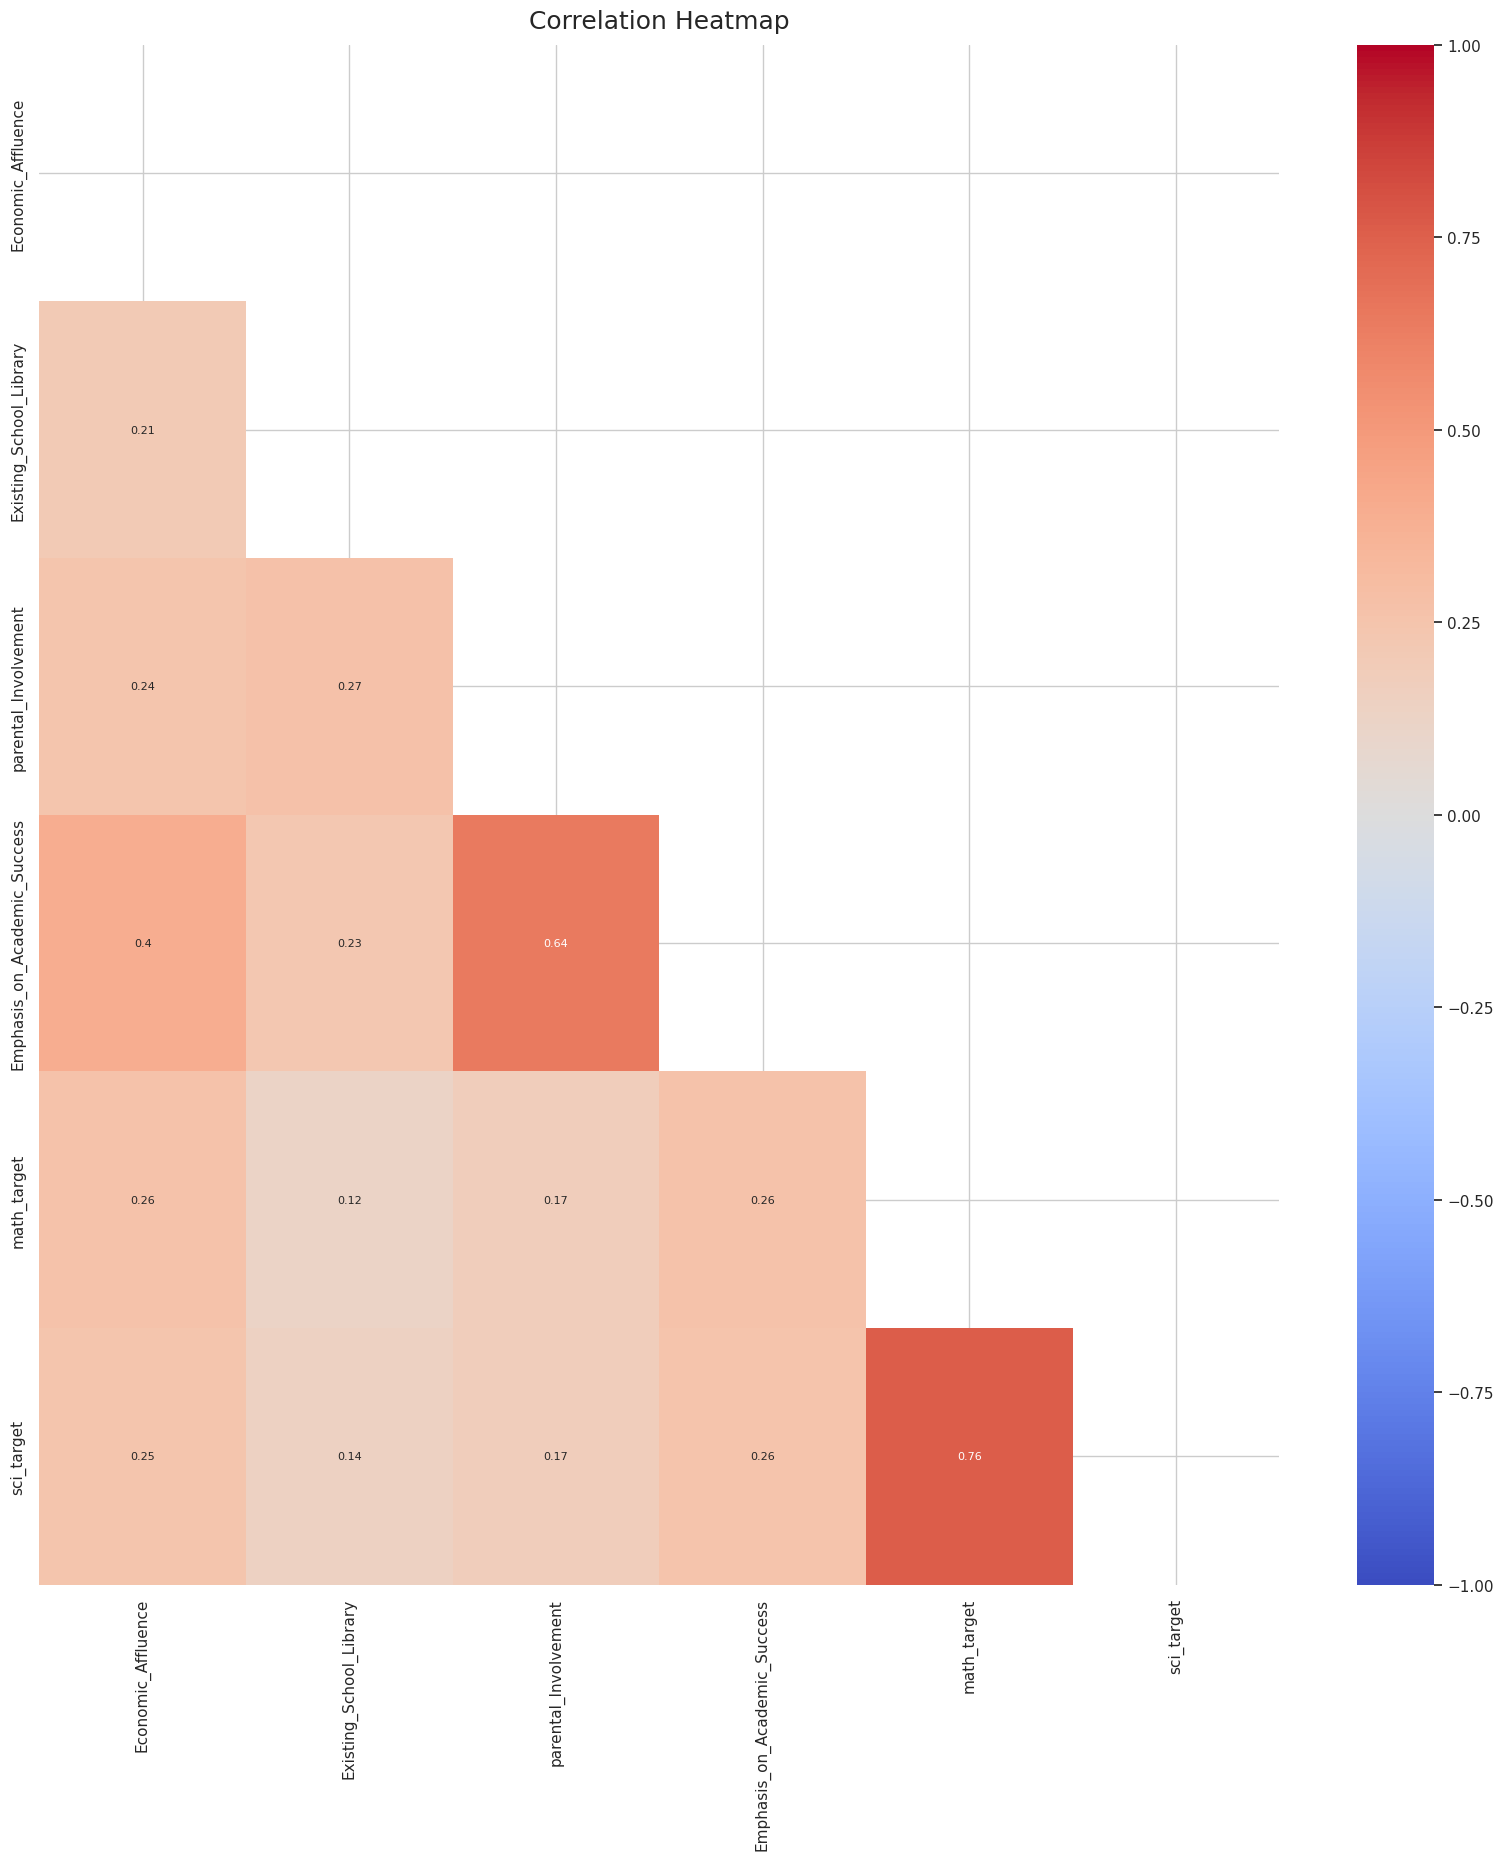

Columns with correlation greater than 0.1: ['Economic_Affluence', 'Existing_School_Library', 'parental_Involvement', 'Emphasis_on_Academic_Success', 'math_target', 'sci_target']


In [ ]:
plt.figure(figsize=(20, 20))
delete_columns=['School_ID','Student_ID']
school_ach_ID=school_ach.copy()
school_ach=school_ach.drop(delete_columns, axis=1)
corr_matrix=school_ach.corr()
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 20))
heatmap =sns.heatmap(corr_matrix,vmin=-1, vmax=1, annot=True,cmap=sns.color_palette("coolwarm", as_cmap=True),annot_kws={"size": 8}, mask=mask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.show()

corr_with_target=corr_matrix['sci_target']
# Select column names with correlation greater than 0.1
threshold = 0.1

high_corr_columns = corr_with_target[corr_with_target.abs() > threshold].index.tolist()

print("Columns with correlation greater than 0.1:", high_corr_columns)

In [ ]:
corr_with_target=corr_matrix['math_target']
# Select column names with correlation greater than 0.1
threshold = 0.1

high_corr_columns = corr_with_target[corr_with_target.abs() > threshold].index.tolist()

print("Columns with correlation greater than 0.1:", high_corr_columns)

Columns with correlation greater than 0.1: ['Economic_Affluence', 'Existing_School_Library', 'parental_Involvement', 'Emphasis_on_Academic_Success', 'math_target', 'sci_target']


In [ ]:
X=school_ach.drop(['sci_target','math_target'], axis=1)
y=school_ach['sci_target']
get_models(X, y, 4)

logistic regression
Accuracy: 0.62
Precision: 0.64
Recall: 0.57
F1 Score: 0.60
column Economic_Affluence, 1
column Existing_School_Library, 1
column parental_Involvement, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.67
Precision: 0.68
Recall: 0.65
F1 Score: 0.66
column Economic_Affluence, 1
column Existing_School_Library, 1
column parental_Involvement, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.67
Precision: 0.69
Recall: 0.63
F1 Score: 0.66
column Economic_Affluence, 1
column Existing_School_Library, 1
column parental_Involvement, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.64
Precision: 0.64
Recall: 0.68
F1 Score: 0.66
column Economic_Affluence, 1
column Existing_School_Library, 1
column parental_Involvement, 1
column Emphasis_on_Academic_Success, 1
------------------


In [ ]:
X=school_ach.drop(['sci_target','math_target'], axis=1)
y=school_ach['math_target']
get_models(X, y, 4)

logistic regression
Accuracy: 0.60
Precision: 0.61
Recall: 0.50
F1 Score: 0.55
column Economic_Affluence, 1
column Existing_School_Library, 1
column parental_Involvement, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.67
Precision: 0.68
Recall: 0.61
F1 Score: 0.65
column Economic_Affluence, 1
column Existing_School_Library, 1
column parental_Involvement, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.67
Precision: 0.68
Recall: 0.62
F1 Score: 0.65
column Economic_Affluence, 1
column Existing_School_Library, 1
column parental_Involvement, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.66
Precision: 0.67
Recall: 0.61
F1 Score: 0.64
column Economic_Affluence, 1
column Existing_School_Library, 1
column parental_Involvement, 1
column Emphasis_on_Academic_Success, 1
------------------


# combined datasets

In [ ]:
student_filtered_ach_filtered_ID.head()

,Country_ID,School_ID,Class_ID,Student_ID,Gender,Books_at_Home,Home_Computer_Tablet,Home_Own_Room,Home_Internet_Connection,Home_Own_Mobile_Phone,Parent_A_Education,Parent_B_Education,Education_Expectation,Enjoy_Math,Math_is_Boring,Do_Well_in_Math,Math_is_Difficult,Enjoy_Science,Science_is_Boring,Do_Well_in_Science,Science_is_Difficult,absent,belog_at_school,sci_target,math_target
1,364.0,5001.0,500104.0,50010402.0,0.0,4.0,1.0,1.0,1.0,1.0,5.0,5.0,6,2.0,2.0,2.0,0.0,2.0,1.0,3.0,1.0,2,0.0,1,1
2,364.0,5001.0,500104.0,50010403.0,0.0,4.0,1.0,1.0,1.0,1.0,6.0,6.0,5,0.0,3.0,0.0,3.0,3.0,0.0,2.0,1.0,2,0.0,0,0
3,364.0,5001.0,500104.0,50010404.0,0.0,2.0,1.0,0.0,1.0,1.0,3.0,3.0,5,1.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,1,1.0,1,1
4,364.0,5001.0,500104.0,50010405.0,0.0,2.0,1.0,1.0,1.0,1.0,6.0,6.0,6,3.0,1.0,3.0,0.0,2.0,2.0,2.0,2.0,3,2.0,0,1
5,364.0,5001.0,500104.0,50010406.0,0.0,4.0,1.0,1.0,1.0,0.0,5.0,5.0,5,2.0,2.0,1.0,2.0,2.0,3.0,2.0,1.0,1,0.0,1,1


In [ ]:
delete_columns=['IDCNTRY','IDSCHOOL', 'IDTEACH','IDSTUD','IDBOOK',]
math_teacher_student_ach_ID=math_teacher_student_ach_ID.drop(delete_columns, axis=1)
math_teacher_student_ach_ID.head()

,Years_Teaching,Education_Level_Completed,Major_Mathematics,Major_Biology,Major_Physics,Major_Chemistry,Major_Earth_Science,Major_Edu_Mathematics,Major_Edu_Science,Major_Edu_General,Ask_Explain_New_Content,Ask_Explain_How_to_Solve,Ask_Memorize_Rules,Ask_Practice_Procedures,Ask_Apply_Learned_Concepts,Ask_Work_in_Whole_Class,Ask_Mixed_Ability_Groups,Ask_Same_Ability_Groups,Homework_Assigned_Frequency,Time_Spent_on_Homework,Computer_Tablet_Availability,Number_of_Students_in_Class,School_Emphasis_Academic_Success,Teaching_Limited_by_Student_Needs,Country_ID,School_ID,Student_ID,math_target
0,27.0,4.0,1.0,0,0,0,0.0,0,0,0,3,2.0,1,1,1,1,2.0,1.0,3.0,2.0,0,33.0,7.93956,9.11668,364.0,5001.0,50010402.0,1
1,27.0,4.0,1.0,0,0,0,0.0,0,0,0,3,2.0,1,1,1,1,2.0,1.0,3.0,2.0,0,33.0,7.93956,9.11668,364.0,5001.0,50010403.0,0
2,27.0,4.0,1.0,0,0,0,0.0,0,0,0,3,2.0,1,1,1,1,2.0,1.0,3.0,2.0,0,33.0,7.93956,9.11668,364.0,5001.0,50010404.0,1
3,27.0,4.0,1.0,0,0,0,0.0,0,0,0,3,2.0,1,1,1,1,2.0,1.0,3.0,2.0,0,33.0,7.93956,9.11668,364.0,5001.0,50010405.0,1
4,27.0,4.0,1.0,0,0,0,0.0,0,0,0,3,2.0,1,1,1,1,2.0,1.0,3.0,2.0,0,33.0,7.93956,9.11668,364.0,5001.0,50010406.0,1


In [ ]:
delete_columns=['IDCNTRY','IDSCHOOL', 'IDTEACH','IDSTUD','IDBOOK',]
sci_teacher_student_ach_ID=sci_teacher_student_ach_ID.drop(delete_columns, axis=1)
sci_teacher_student_ach_ID.head()

,Years_Teaching,Education_Level_Completed,Major_Mathematics,Major_Biology,Major_Physics,Major_Chemistry,Major_Earth_Science,Major_Edu_Mathematics,Major_Edu_Science,Major_Edu_General,Ask_Explain_New_Content,Ask_Observe_Phenomena,Ask_Demonstrate_Experiment,Ask_Plan_Experiments,Ask_Conduct_Experiments,Ask_Present_Data,Ask_Interpret_Data,Ask_Use_Evidence,Ask_Read_Textbooks,Ask_Memorize_Facts,Ask_Use_Formulas,Ask_Do_Field_Work,Ask_Mixed_Ability_Groups,Ask_Same_Ability_Groups,Frequency_Sci_Homework,Time_Spent_Homework,Computer_Tablet_Availability,Class_Size,School_Emphasis_Academic_Success,Teachers_Emphasis_Science_Investigation,Country_ID,School_ID,Student_ID,sci_target
0,21.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2,2,2.0,2.0,1.0,1.0,2.0,2,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1,33.0,7.93956,10.24199,364.0,5001.0,50010402.0,1
1,21.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2,2,2.0,2.0,1.0,1.0,2.0,2,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1,33.0,7.93956,10.24199,364.0,5001.0,50010403.0,0
2,21.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2,2,2.0,2.0,1.0,1.0,2.0,2,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1,33.0,7.93956,10.24199,364.0,5001.0,50010404.0,1
3,21.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2,2,2.0,2.0,1.0,1.0,2.0,2,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1,33.0,7.93956,10.24199,364.0,5001.0,50010405.0,0
4,21.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2,2,2.0,2.0,1.0,1.0,2.0,2,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1,33.0,7.93956,10.24199,364.0,5001.0,50010406.0,1


In [ ]:
school_ach_ID.head()

,School_ID,Economic_Affluence,Existing_School_Library,parental_Involvement,Emphasis_on_Academic_Success,Student_ID,math_target,sci_target
0,5001.0,2.0,1,2.0,9.56054,50010401.0,1,1
1,5001.0,2.0,1,2.0,9.56054,50010402.0,1,1
2,5001.0,2.0,1,2.0,9.56054,50010403.0,0,0
3,5001.0,2.0,1,2.0,9.56054,50010404.0,1,1
4,5001.0,2.0,1,2.0,9.56054,50010405.0,1,0


## math

In [ ]:
student_math_teacher=pd.merge(student_filtered_ach_filtered_ID, math_teacher_student_ach_ID, on='Student_ID')

In [ ]:
student_math_teacher_school=pd.merge(student_math_teacher, school_ach_ID, on='Student_ID' )

In [ ]:
selected_columns=['Years_Teaching', 'Number_of_Students_in_Class', 'School_Emphasis_Academic_Success', 'Teaching_Limited_by_Student_Needs',
                  'Books_at_Home', 'Home_Internet_Connection', 'Parent_A_Education','Parent_B_Education', 'Education_Expectation','Do_Well_in_Math', 'Math_is_Difficult', 'Science_is_Difficult', 'absent','belog_at_school',
                 'math_target_x',
                  'Student_ID','School_ID_x',
                  'Economic_Affluence','Existing_School_Library','parental_Involvement','Emphasis_on_Academic_Success']
student_math_teacher_school = student_math_teacher_school[selected_columns]
student_math_teacher_school.rename(columns={'math_target_x':'math_target','School_ID_x':'School_ID' }, inplace=True)

In [ ]:
student_math_teacher_school.head()

,Years_Teaching,Number_of_Students_in_Class,School_Emphasis_Academic_Success,Teaching_Limited_by_Student_Needs,Books_at_Home,Home_Internet_Connection,Parent_A_Education,Parent_B_Education,Education_Expectation,Do_Well_in_Math,Math_is_Difficult,Science_is_Difficult,absent,belog_at_school,math_target,Student_ID,School_ID,Economic_Affluence,Existing_School_Library,parental_Involvement,Emphasis_on_Academic_Success
0,27.0,33.0,7.93956,9.11668,4.0,1.0,5.0,5.0,6,2.0,0.0,1.0,2,0.0,1,50010402.0,5001.0,2.0,1,2.0,9.56054
1,27.0,33.0,7.93956,9.11668,4.0,1.0,6.0,6.0,5,0.0,3.0,1.0,2,0.0,0,50010403.0,5001.0,2.0,1,2.0,9.56054
2,27.0,33.0,7.93956,9.11668,2.0,1.0,3.0,3.0,5,2.0,2.0,2.0,1,1.0,1,50010404.0,5001.0,2.0,1,2.0,9.56054
3,27.0,33.0,7.93956,9.11668,2.0,1.0,6.0,6.0,6,3.0,0.0,2.0,3,2.0,1,50010405.0,5001.0,2.0,1,2.0,9.56054
4,27.0,33.0,7.93956,9.11668,4.0,1.0,5.0,5.0,5,1.0,2.0,1.0,1,0.0,1,50010406.0,5001.0,2.0,1,2.0,9.56054


In [ ]:

X=student_math_teacher_school.drop(['Student_ID', 'School_ID', 'math_target'],axis=1)
y=student_math_teacher_school['math_target']

In [ ]:

# get a list of models to evaluate
def get_models(X, y, n_features_to_select=10):
  f1_lr=0
  acc_lr=0

  f1_dt=0
  acc_dt=0

  f1_rf=0
  acc_rf=0

  f1_gb=0
  acc_gb=0

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	# lr
  rfe = RFE(estimator=LogisticRegression(), n_features_to_select=n_features_to_select)
  # fit RFE
  rfe.fit(X_train, y_train)
  # summarize all features
  print('logistic regression')
  y_pred = rfe.predict(X_test)
  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1 Score: {f1:.2f}')
  f1_lr=f1
  acc_lr=accuracy
  for i in range(X.shape[1]):
    if rfe.support_[i]:
      print(f'column {X.columns[i]}, {rfe.ranking_[i]}')
  print('------------------')



	# cart
  rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n_features_to_select)
  # fit RFE
  rfe.fit(X_train, y_train)
  # summarize all features
  print('decision tree')
  y_pred = rfe.predict(X_test)
  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1 Score: {f1:.2f}')
  f1_dt=f1
  acc_dt=accuracy
  for i in range(X.shape[1]):
    if rfe.support_[i]:
      print(f'column {X.columns[i]}, {rfe.ranking_[i]}')
  print('------------------')

	# rf
  rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=n_features_to_select)
  # fit RFE
  rfe.fit(X_train, y_train)
  # summarize all features
  print('random forest')
  y_pred = rfe.predict(X_test)
  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1 Score: {f1:.2f}')
  f1_rf=f1
  acc_rf=accuracy
  for i in range(X.shape[1]):
    if rfe.support_[i]:
      print(f'column {X.columns[i]}, {rfe.ranking_[i]}')
  print('------------------')


	# gbm
  rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=n_features_to_select)
  # fit RFE
  rfe.fit(X_train, y_train)
  # summarize all features
  print('gradient bossting')
  y_pred = rfe.predict(X_test)
  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.2f}')
  print(f'Precision: {precision:.2f}')
  print(f'Recall: {recall:.2f}')
  print(f'F1 Score: {f1:.2f}')
  f1_gb=f1
  acc_gb=accuracy
  for i in range(X.shape[1]):
    if rfe.support_[i]:
      print(f'column {X.columns[i]}, {rfe.ranking_[i]}')
  print('------------------')
  return f1_lr, acc_lr, f1_dt, acc_dt, f1_rf, acc_rf, f1_gb, acc_gb

In [ ]:
math={k:{'f1':[],'accuracy':[]} for k in range(1,19)}
for number_of_features in range(18,0, -1):
  print('number of features:', number_of_features)
  f1_lr, acc_lr, f1_dt, acc_dt, f1_rf, acc_rf, f1_gb, acc_gb=get_models(X, y, number_of_features)
  math[number_of_features]['f1']=[f1_lr, f1_dt, f1_rf, f1_gb]
  math[number_of_features]['accuracy']=[acc_lr, acc_dt, acc_rf, acc_gb]
  print('-----------------------------------------------------------')

number of features: 18
logistic regression
Accuracy: 0.74
Precision: 0.75
Recall: 0.74
F1 Score: 0.75
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teaching_Limited_by_Student_Needs, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column absent, 1
column belog_at_school, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column parental_Involvement, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.69
Precision: 0.70
Recall: 0.71
F1 Score: 0.70
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teaching_Limited_by_Student_Needs, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column P

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


random forest
Accuracy: 0.77
Precision: 0.77
Recall: 0.79
F1 Score: 0.78
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teaching_Limited_by_Student_Needs, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column absent, 1
column belog_at_school, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column parental_Involvement, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.77
Precision: 0.77
Recall: 0.79
F1 Score: 0.78
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teaching_Limited_by_Student_Needs, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
colu

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

decision tree
Accuracy: 0.70
Precision: 0.71
Recall: 0.70
F1 Score: 0.70
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teaching_Limited_by_Student_Needs, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column absent, 1
column belog_at_school, 1
column Economic_Affluence, 1
column parental_Involvement, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.76
Precision: 0.76
Recall: 0.77
F1 Score: 0.76
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teaching_Limited_by_Student_Needs, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.74
Precision: 0.75
Recall: 0.74
F1 Score: 0.75
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column absent, 1
column belog_at_school, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.70
Precision: 0.70
Recall: 0.72
F1 Score: 0.71
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teaching_Limited_by_Student_Needs, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficul

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.75
Precision: 0.76
Recall: 0.75
F1 Score: 0.75
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column absent, 1
column belog_at_school, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.69
Precision: 0.69
Recall: 0.72
F1 Score: 0.71
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teaching_Limited_by_Student_Needs, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column absent, 1
col

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.75
Precision: 0.75
Recall: 0.76
F1 Score: 0.75
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column absent, 1
column belog_at_school, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.69
Precision: 0.69
Recall: 0.74
F1 Score: 0.71
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teaching_Limited_by_Student_Needs, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column absent, 1
column belog_at_school, 1
column Emphasis

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.75
Precision: 0.75
Recall: 0.76
F1 Score: 0.76
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column absent, 1
column belog_at_school, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.69
Precision: 0.70
Recall: 0.69
F1 Score: 0.69
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teaching_Limited_by_Student_Needs, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column belog_at_school, 1
column Emphasis_on_Academic_Success, 1
------------------
ran

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.75
Precision: 0.75
Recall: 0.76
F1 Score: 0.76
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column absent, 1
column belog_at_school, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.68
Precision: 0.69
Recall: 0.69
F1 Score: 0.69
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teaching_Limited_by_Student_Needs, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.75
Precision: 0.76
Recall: 0.76
F1 Score: 0.76

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.75
Precision: 0.75
Recall: 0.76
F1 Score: 0.75
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column belog_at_school, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.70
Precision: 0.71
Recall: 0.70
F1 Score: 0.71
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.75
Precision: 0.76
Recall: 0.76
F1 Score: 0.76
column Years_Teaching, 1
column Number_of_Students_in_Class,

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.74
Precision: 0.74
Recall: 0.75
F1 Score: 0.75
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column belog_at_school, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.69
Precision: 0.70
Recall: 0.71
F1 Score: 0.71
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.75
Precision: 0.76
Recall: 0.77
F1 Score: 0.76
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Teachin

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.73
Precision: 0.73
Recall: 0.75
F1 Score: 0.74
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column belog_at_school, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
------------------
decision tree
Accuracy: 0.70
Precision: 0.71
Recall: 0.71
F1 Score: 0.71
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.75
Precision: 0.75
Recall: 0.77
F1 Score: 0.76
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Parent_B_Education, 1
column Education_Expectation,

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.73
Precision: 0.74
Recall: 0.74
F1 Score: 0.74
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
------------------
decision tree
Accuracy: 0.68
Precision: 0.69
Recall: 0.69
F1 Score: 0.69
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.74
Precision: 0.73
Recall: 0.78
F1 Score: 0.76
column Years_Teaching, 1
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Math_is_Difficult, 1
column Emphasis_on_Academic_Succe

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.72
Precision: 0.73
Recall: 0.74
F1 Score: 0.73
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
------------------
decision tree
Accuracy: 0.68
Precision: 0.69
Recall: 0.68
F1 Score: 0.69
column Number_of_Students_in_Class, 1
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Education_Expectation, 1
column Math_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.73
Precision: 0.73
Recall: 0.77
F1 Score: 0.75
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Math_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.76
Precision: 0.75
Recall: 0

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.73
Precision: 0.73
Recall: 0.75
F1 Score: 0.74
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column Economic_Affluence, 1
------------------
decision tree
Accuracy: 0.69
Precision: 0.70
Recall: 0.68
F1 Score: 0.69
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Parent_A_Education, 1
column Education_Expectation, 1
column Math_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.73
Precision: 0.72
Recall: 0.77
F1 Score: 0.74
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Parent_B_Education, 1
column Math_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.74
Precision: 0.74
Recall: 0.78
F1 Score: 0.76
column Books_at_Home, 1
column Parent_A_Education, 1
column Education_Expectation, 1

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.72
Precision: 0.72
Recall: 0.73
F1 Score: 0.73
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Economic_Affluence, 1
------------------
decision tree
Accuracy: 0.66
Precision: 0.70
Recall: 0.61
F1 Score: 0.65
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Parent_A_Education, 1
column Education_Expectation, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.69
Precision: 0.69
Recall: 0.73
F1 Score: 0.71
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Parent_B_Education, 1
column Math_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.75
Precision: 0.74
Recall: 0.78
F1 Score: 0.76
column Books_at_Home, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.70
Precision: 0.70
Recall: 0.74
F1 Score: 0.72
column Home_Internet_Connection, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Economic_Affluence, 1
------------------
decision tree
Accuracy: 0.65
Precision: 0.69
Recall: 0.60
F1 Score: 0.64
column Number_of_Students_in_Class, 1
column Parent_A_Education, 1
column Education_Expectation, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.69
Precision: 0.70
Recall: 0.68
F1 Score: 0.69
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Parent_B_Education, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.72
Precision: 0.72
Recall: 0.76
F1 Score: 0.74
column Books_at_Home, 1
column Education_Expectation, 1
column Math_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
-----------------------------------------------------------
number of features: 3


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.69
Precision: 0.70
Recall: 0.67
F1 Score: 0.69
column Home_Internet_Connection, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
------------------
decision tree
Accuracy: 0.70
Precision: 0.71
Recall: 0.70
F1 Score: 0.70
column School_Emphasis_Academic_Success, 1
column Education_Expectation, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.68
Precision: 0.70
Recall: 0.66
F1 Score: 0.68
column School_Emphasis_Academic_Success, 1
column Parent_B_Education, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.69
Precision: 0.68
Recall: 0.75
F1 Score: 0.71
column Books_at_Home, 1
column Education_Expectation, 1
column Math_is_Difficult, 1
------------------
-----------------------------------------------------------
number of features: 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.65
Precision: 0.69
Recall: 0.59
F1 Score: 0.64
column Home_Internet_Connection, 1
column Math_is_Difficult, 1
------------------
decision tree
Accuracy: 0.70
Precision: 0.72
Recall: 0.69
F1 Score: 0.71
column School_Emphasis_Academic_Success, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.70
Precision: 0.71
Recall: 0.70
F1 Score: 0.71
column School_Emphasis_Academic_Success, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.67
Precision: 0.68
Recall: 0.65
F1 Score: 0.67
column Education_Expectation, 1
column Math_is_Difficult, 1
------------------
-----------------------------------------------------------
number of features: 1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.60
Precision: 0.58
Recall: 0.85
F1 Score: 0.69
column Home_Internet_Connection, 1
------------------
decision tree
Accuracy: 0.63
Precision: 0.64
Recall: 0.65
F1 Score: 0.64
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.63
Precision: 0.64
Recall: 0.65
F1 Score: 0.64
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.64
Precision: 0.60
Recall: 0.91
F1 Score: 0.72
column Education_Expectation, 1
------------------
-----------------------------------------------------------


In [ ]:
print(math)

{1: {'f1': [0.687447346251053, 0.6441717791411044, 0.6441717791411044, 0.7202625102543067], 'accuracy': [0.6032085561497326, 0.627807486631016, 0.627807486631016, 0.6352941176470588]}, 2: {'f1': [0.6361607142857142, 0.7055084745762711, 0.7056367432150313, 0.6680805938494168], 'accuracy': [0.651336898395722, 0.7026737967914438, 0.6983957219251337, 0.66524064171123]}, 3: {'f1': [0.6878980891719745, 0.7029288702928871, 0.6766275346851653, 0.710059171597633], 'accuracy': [0.6855614973262032, 0.6962566844919786, 0.6759358288770053, 0.6855614973262032]}, 4: {'f1': [0.7223340040241449, 0.6407119021134594, 0.6933614330874605, 0.7396984924623115], 'accuracy': [0.704812834224599, 0.6545454545454545, 0.6887700534759358, 0.7229946524064171]}, 5: {'f1': [0.7276464542651593, 0.6512141280353201, 0.7103935418768919, 0.7600806451612905], 'accuracy': [0.7165775401069518, 0.6620320855614973, 0.6930481283422459, 0.7454545454545455]}, 6: {'f1': [0.7423312883435582, 0.6925498426023085, 0.744, 0.757575757575

In [ ]:
# Extract number of features and F1 scores for each model
num_features = list(math.keys())
f1_logistic = [math[n]['f1'][0] for n in num_features]
f1_decision_tree = [math[n]['f1'][1] for n in num_features]
f1_random_forest = [math[n]['f1'][2] for n in num_features]
f1_gradient_boosting = [math[n]['f1'][3] for n in num_features]

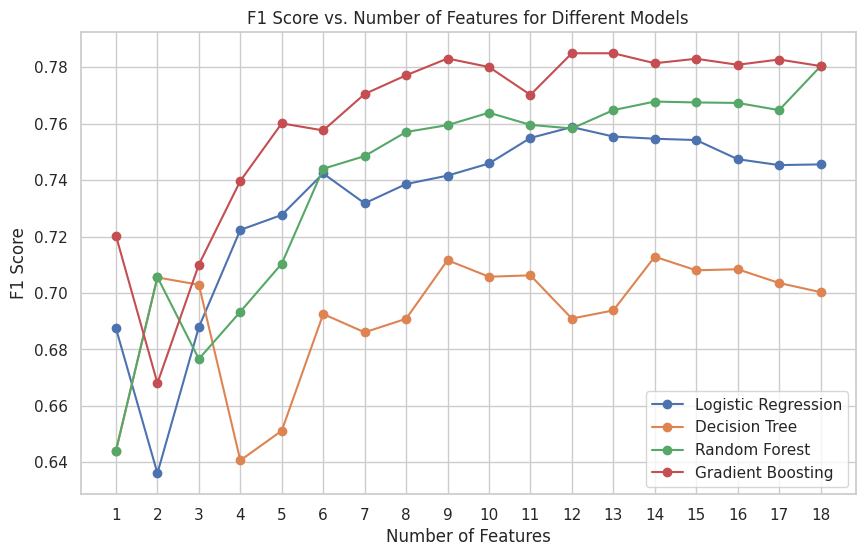

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(num_features, f1_logistic, label='Logistic Regression', marker='o')
plt.plot(num_features, f1_decision_tree, label='Decision Tree', marker='o')
plt.plot(num_features, f1_random_forest, label='Random Forest', marker='o')
plt.plot(num_features, f1_gradient_boosting, label='Gradient Boosting', marker='o')

plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Number of Features for Different Models')
plt.xticks(range(1, 19))
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Extract number of features and accuracy scores for each model
num_features = list(math.keys())
accuracy_logistic = [math[n]['accuracy'][0] for n in num_features]
accuracy_decision_tree = [math[n]['accuracy'][1] for n in num_features]
accuracy_random_forest = [math[n]['accuracy'][2] for n in num_features]
accuracy_gradient_boosting = [math[n]['accuracy'][3] for n in num_features]

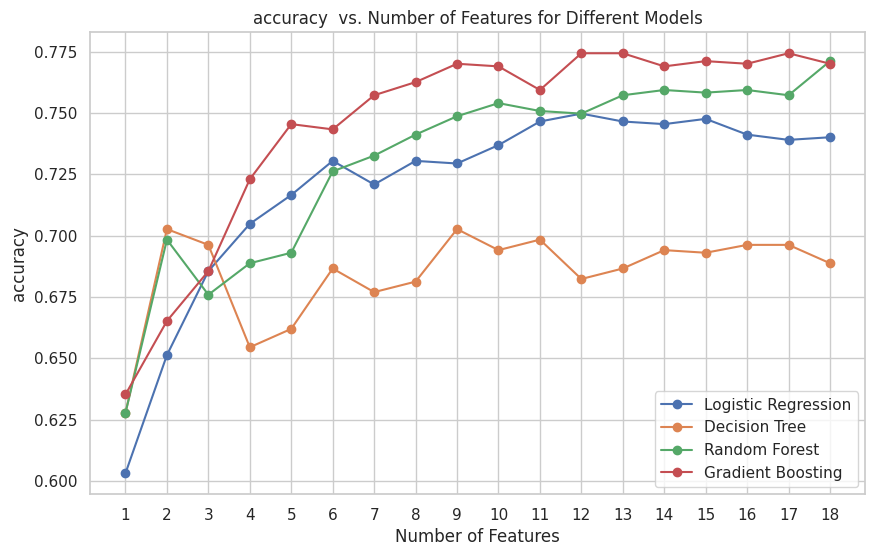

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(num_features, accuracy_logistic, label='Logistic Regression', marker='o')
plt.plot(num_features, accuracy_decision_tree, label='Decision Tree', marker='o')
plt.plot(num_features, accuracy_random_forest, label='Random Forest', marker='o')
plt.plot(num_features, accuracy_gradient_boosting, label='Gradient Boosting', marker='o')

plt.xlabel('Number of Features')
plt.ylabel('accuracy')
plt.title('accuracy  vs. Number of Features for Different Models')
plt.xticks(range(1, 19))
plt.legend()
plt.grid(True)
plt.show()


##science

In [ ]:
student_sci_teacher=pd.merge(student_filtered_ach_filtered_ID, sci_teacher_student_ach_ID, on='Student_ID')

In [ ]:
student_sci_teacher_school=pd.merge(student_sci_teacher, school_ach_ID, on='Student_ID' )

In [ ]:
selected_columns=['Years_Teaching', 'Class_Size', 'School_Emphasis_Academic_Success', 'Teachers_Emphasis_Science_Investigation',
                  'Books_at_Home', 'Home_Internet_Connection', 'Parent_A_Education','Parent_B_Education', 'Education_Expectation','Do_Well_in_Math', 'Math_is_Difficult', 'Science_is_Boring', 'Science_is_Difficult','absent',
                 'sci_target_x',
                  'Student_ID','School_ID_x',
                  'Economic_Affluence','Existing_School_Library','parental_Involvement','Emphasis_on_Academic_Success']
student_sci_teacher_school = student_sci_teacher_school[selected_columns]
student_sci_teacher_school.rename(columns={'sci_target_x':'sci_target','School_ID_x':'School_ID' }, inplace=True)

In [ ]:
student_sci_teacher_school.head()

,Years_Teaching,Class_Size,School_Emphasis_Academic_Success,Teachers_Emphasis_Science_Investigation,Books_at_Home,Home_Internet_Connection,Parent_A_Education,Parent_B_Education,Education_Expectation,Do_Well_in_Math,Math_is_Difficult,Science_is_Boring,Science_is_Difficult,absent,sci_target,Student_ID,School_ID,Economic_Affluence,Existing_School_Library,parental_Involvement,Emphasis_on_Academic_Success
0,21.0,33.0,7.93956,10.24199,4.0,1.0,5.0,5.0,6,2.0,0.0,1.0,1.0,2,1,50010402.0,5001.0,2.0,1,2.0,9.56054
1,21.0,33.0,7.93956,10.24199,4.0,1.0,6.0,6.0,5,0.0,3.0,0.0,1.0,2,0,50010403.0,5001.0,2.0,1,2.0,9.56054
2,21.0,33.0,7.93956,10.24199,2.0,1.0,3.0,3.0,5,2.0,2.0,2.0,2.0,1,1,50010404.0,5001.0,2.0,1,2.0,9.56054
3,21.0,33.0,7.93956,10.24199,2.0,1.0,6.0,6.0,6,3.0,0.0,2.0,2.0,3,0,50010405.0,5001.0,2.0,1,2.0,9.56054
4,21.0,33.0,7.93956,10.24199,4.0,1.0,5.0,5.0,5,1.0,2.0,3.0,1.0,1,1,50010406.0,5001.0,2.0,1,2.0,9.56054


In [ ]:
X=student_sci_teacher_school.drop(['Student_ID', 'School_ID', 'sci_target'],axis=1)
y=student_sci_teacher_school['sci_target']

In [ ]:
science={k:{'f1':[],'accuracy':[]} for k in range(1,19)}
for number_of_features in range(18,0, -1):
  print('number of features:', number_of_features)
  f1_lr, acc_lr, f1_dt, acc_dt, f1_rf, acc_rf, f1_gb, acc_gb=get_models(X, y, number_of_features)
  science[number_of_features]['f1']=[f1_lr, f1_dt, f1_rf, f1_gb]
  science[number_of_features]['accuracy']=[acc_lr, acc_dt, acc_rf, acc_gb]
  print('-----------------------------------------------------------')

number of features: 18


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic regression
Accuracy: 0.77
Precision: 0.78
Recall: 0.78
F1 Score: 0.78
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Boring, 1
column Science_is_Difficult, 1
column absent, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column parental_Involvement, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.67
Precision: 0.68
Recall: 0.71
F1 Score: 0.69
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expec

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.76
Precision: 0.77
Recall: 0.78
F1 Score: 0.78
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Boring, 1
column Science_is_Difficult, 1
column absent, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column parental_Involvement, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.67
Precision: 0.68
Recall: 0.70
F1 Score: 0.69
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_W

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.76
Precision: 0.77
Recall: 0.78
F1 Score: 0.77
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Boring, 1
column Science_is_Difficult, 1
column absent, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.66
Precision: 0.68
Recall: 0.69
F1 Score: 0.68
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Borin

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.76
Precision: 0.77
Recall: 0.77
F1 Score: 0.77
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Boring, 1
column Science_is_Difficult, 1
column absent, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.69
Precision: 0.69
Recall: 0.72
F1 Score: 0.71
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Boring, 1
column Science_is_Difficult, 1
column Economi

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.76
Precision: 0.78
Recall: 0.77
F1 Score: 0.77
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Boring, 1
column Science_is_Difficult, 1
column absent, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.66
Precision: 0.68
Recall: 0.68
F1 Score: 0.68
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Boring, 1
column Science_is_Difficult, 1
column absent, 1
column Emphasis_on_Aca

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.76
Precision: 0.77
Recall: 0.77
F1 Score: 0.77
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Boring, 1
column Science_is_Difficult, 1
column absent, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.67
Precision: 0.68
Recall: 0.68
F1 Score: 0.68
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Boring, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.76
Precision: 0.77
Recall: 0.77
F1 Score: 0.77
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Boring, 1
column Science_is_Difficult, 1
column absent, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.67
Precision: 0.67
Recall: 0.73
F1 Score: 0.70
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.77
Precision: 0.77
Recall: 0.80
F1 Score: 0.78
column Y

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.76
Precision: 0.78
Recall: 0.77
F1 Score: 0.78
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Boring, 1
column Science_is_Difficult, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
column Emphasis_on_Academic_Success, 1
------------------
decision tree
Accuracy: 0.67
Precision: 0.69
Recall: 0.69
F1 Score: 0.69
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.75
Precision: 0.75
Recall: 0.79
F1 Score: 0.77
column Years_Teaching, 1
column Class_Size, 1
column 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.75
Precision: 0.76
Recall: 0.77
F1 Score: 0.77
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Boring, 1
column Science_is_Difficult, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
------------------
decision tree
Accuracy: 0.68
Precision: 0.69
Recall: 0.69
F1 Score: 0.69
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.76
Precision: 0.75
Recall: 0.80
F1 Score: 0.78
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Scie

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.74
Precision: 0.76
Recall: 0.76
F1 Score: 0.76
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Do_Well_in_Math, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
------------------
decision tree
Accuracy: 0.68
Precision: 0.71
Recall: 0.67
F1 Score: 0.69
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.74
Precision: 0.74
Recall: 0.77
F1 Score: 0.76
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Parent_B_Education, 1
column Education_Expectation,

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.74
Precision: 0.76
Recall: 0.75
F1 Score: 0.75
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
------------------
decision tree
Accuracy: 0.66
Precision: 0.69
Recall: 0.65
F1 Score: 0.67
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Parent_A_Education, 1
column Education_Expectation, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.73
Precision: 0.73
Recall: 0.77
F1 Score: 0.75
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Books_at_Home, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Science_is_Difficult, 1
column Emphasis_o

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.73
Precision: 0.74
Recall: 0.75
F1 Score: 0.75
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Education_Expectation, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
------------------
decision tree
Accuracy: 0.67
Precision: 0.68
Recall: 0.70
F1 Score: 0.69
column School_Emphasis_Academic_Success, 1
column Teachers_Emphasis_Science_Investigation, 1
column Books_at_Home, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.71
Precision: 0.72
Recall: 0.74
F1 Score: 0.73
column Years_Teaching, 1
column Class_Size, 1
column School_Emphasis_Academic_Success, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.74
Prec

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.72
Precision: 0.73
Recall: 0.74
F1 Score: 0.74
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column Economic_Affluence, 1
column Existing_School_Library, 1
------------------
decision tree
Accuracy: 0.67
Precision: 0.71
Recall: 0.64
F1 Score: 0.67
column Years_Teaching, 1
column Teachers_Emphasis_Science_Investigation, 1
column Parent_A_Education, 1
column Education_Expectation, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.71
Precision: 0.71
Recall: 0.74
F1 Score: 0.73
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.75
Precision: 0.75
Recall: 0.78
F1 Score: 0.77
column Books_at_Home, 1
column Parent_A_Education, 1
co

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.70
Precision: 0.71
Recall: 0.73
F1 Score: 0.72
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column Existing_School_Library, 1
------------------
decision tree
Accuracy: 0.69
Precision: 0.73
Recall: 0.65
F1 Score: 0.68
column Years_Teaching, 1
column Teachers_Emphasis_Science_Investigation, 1
column Parent_A_Education, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.68
Precision: 0.70
Recall: 0.70
F1 Score: 0.70
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Parent_B_Education, 1
column Education_Expectation, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.75
Precision: 0.76
Recall: 0.78
F1 Score: 0.77
column Parent_A_Education, 1
column Education_Expectation, 1
column Math_is_Difficult, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.70
Precision: 0.71
Recall: 0.73
F1 Score: 0.72
column Books_at_Home, 1
column Home_Internet_Connection, 1
column Science_is_Difficult, 1
column Existing_School_Library, 1
------------------
decision tree
Accuracy: 0.72
Precision: 0.74
Recall: 0.71
F1 Score: 0.73
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.70
Precision: 0.71
Recall: 0.74
F1 Score: 0.72
column Years_Teaching, 1
column School_Emphasis_Academic_Success, 1
column Education_Expectation, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.75
Precision: 0.74
Recall: 0.81
F1 Score: 0.78
column Parent_A_Education, 1
column Education_Expectation, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
-----------------------------------------------------------
number of features: 3


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.68
Precision: 0.71
Recall: 0.67
F1 Score: 0.69
column Home_Internet_Connection, 1
column Science_is_Difficult, 1
column Existing_School_Library, 1
------------------
decision tree
Accuracy: 0.70
Precision: 0.72
Recall: 0.71
F1 Score: 0.71
column Class_Size, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.69
Precision: 0.70
Recall: 0.72
F1 Score: 0.71
column School_Emphasis_Academic_Success, 1
column Education_Expectation, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.73
Precision: 0.72
Recall: 0.78
F1 Score: 0.75
column Education_Expectation, 1
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
-----------------------------------------------------------
number of features: 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.62
Precision: 0.62
Recall: 0.73
F1 Score: 0.67
column Home_Internet_Connection, 1
column Existing_School_Library, 1
------------------
decision tree
Accuracy: 0.66
Precision: 0.68
Recall: 0.66
F1 Score: 0.67
column Years_Teaching, 1
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.67
Precision: 0.70
Recall: 0.67
F1 Score: 0.68
column School_Emphasis_Academic_Success, 1
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.70
Precision: 0.70
Recall: 0.75
F1 Score: 0.72
column Science_is_Difficult, 1
column Emphasis_on_Academic_Success, 1
------------------
-----------------------------------------------------------
number of features: 1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression
Accuracy: 0.62
Precision: 0.60
Recall: 0.85
F1 Score: 0.70
column Home_Internet_Connection, 1
------------------
decision tree
Accuracy: 0.62
Precision: 0.62
Recall: 0.76
F1 Score: 0.68
column Emphasis_on_Academic_Success, 1
------------------
random forest
Accuracy: 0.62
Precision: 0.62
Recall: 0.76
F1 Score: 0.68
column Emphasis_on_Academic_Success, 1
------------------
gradient bossting
Accuracy: 0.66
Precision: 0.66
Recall: 0.74
F1 Score: 0.70
column Science_is_Difficult, 1
------------------
-----------------------------------------------------------


In [ ]:
# Extract number of features and F1 scores for each model
num_features = list(science.keys())
f1_logistic = [science[n]['f1'][0] for n in num_features]
f1_decision_tree = [science[n]['f1'][1] for n in num_features]
f1_random_forest = [science[n]['f1'][2] for n in num_features]
f1_gradient_boosting = [science[n]['f1'][3] for n in num_features]

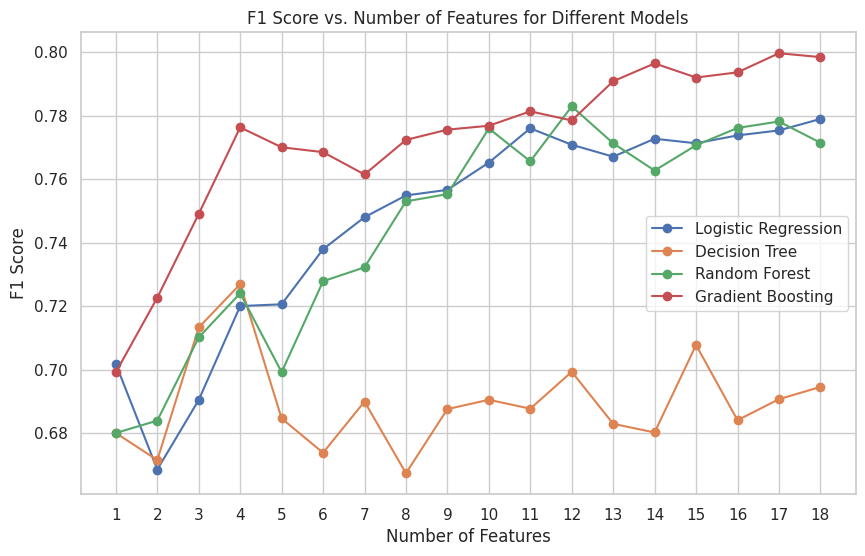

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(num_features, f1_logistic, label='Logistic Regression', marker='o')
plt.plot(num_features, f1_decision_tree, label='Decision Tree', marker='o')
plt.plot(num_features, f1_random_forest, label='Random Forest', marker='o')
plt.plot(num_features, f1_gradient_boosting, label='Gradient Boosting', marker='o')

plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Number of Features for Different Models')
plt.xticks(range(1, 19))
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Extract number of features and F1 scores for each model
num_features = list(science.keys())
accuracy_logistic = [science[n]['accuracy'][0] for n in num_features]
accuracy_decision_tree = [science[n]['accuracy'][1] for n in num_features]
accuracy_random_forest = [science[n]['accuracy'][2] for n in num_features]
accuracy_gradient_boosting = [science[n]['accuracy'][3] for n in num_features]

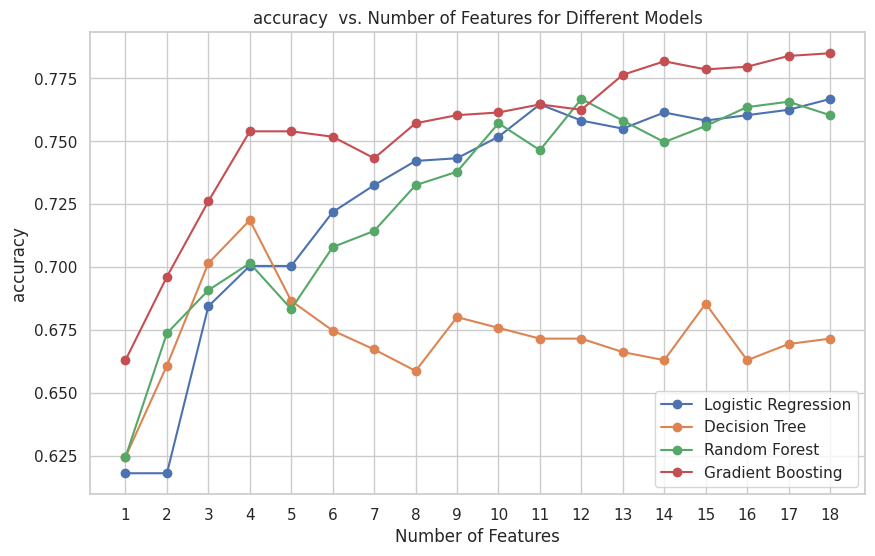

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(num_features, accuracy_logistic, label='Logistic Regression', marker='o')
plt.plot(num_features, accuracy_decision_tree, label='Decision Tree', marker='o')
plt.plot(num_features, accuracy_random_forest, label='Random Forest', marker='o')
plt.plot(num_features, accuracy_gradient_boosting, label='Gradient Boosting', marker='o')

plt.xlabel('Number of Features')
plt.ylabel('accuracy')
plt.title('accuracy  vs. Number of Features for Different Models')
plt.xticks(range(1, 19))
plt.legend()
plt.grid(True)
plt.show()
